# LIBRARIES AND DATA LOADING

In [180]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [181]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.13.0


In [182]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

In [183]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/training-dataset/training_data.npy
/kaggle/input/training-dataset/valid_periods.npy
/kaggle/input/training-dataset/categories.npy


In [184]:
data = np.load('/kaggle/input/training-dataset/training_data.npy', allow_pickle=True)
categories = np.load('/kaggle/input/training-dataset/categories.npy', allow_pickle=True)
valid_periods = np.load('/kaggle/input/training-dataset/valid_periods.npy', allow_pickle=True)

In [185]:
print(data.shape)
print(categories.shape)
print(valid_periods.shape)

(48000, 2776)
(48000,)
(48000, 2)


# CREATE THE DATAFRAME

In [186]:
df = pd.DataFrame(data=data)
df = df.astype(np.float32)
df['Start'] = valid_periods[:,0]
df['End'] = valid_periods[:,1]
df['Categories'] = categories

In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 2779 entries, 0 to Categories
dtypes: float32(2776), int64(2), object(1)
memory usage: 509.4+ MB


In [188]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2769,2770,2771,2772,2773,2774,2775,Start,End,Categories
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.756481,0.744444,0.640741,0.516667,0.602778,0.367593,0.331481,2325,2776,D
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.688000,0.740000,0.640000,0.536000,0.600000,0.460000,0.396000,2325,2776,D
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.916705,0.901249,0.932531,0.955206,0.960481,0.946506,0.977140,2325,2776,D
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.361549,0.430416,0.486370,0.450502,0.470588,0.569584,0.571019,2712,2776,D
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.772727,0.681818,0.704545,0.863636,0.727273,0.818182,0.840909,2682,2776,D


# Statistics

In [189]:
# Create separate DataFrames for each category in category_dataframes
category_groups = df.groupby('Categories')

# Create a dictionary to store DataFrames for each category
category_dataframes = {}

# Iterate over each category and create a DataFrame 
for category, group_df in category_groups:
    category_dataframes[category] = group_df




# SHOW AVERAGE, MAX AND MIN NUMBER OF TIMESTAMPS FOR CATEGORY

In [190]:
# Initialize dictionaries to store results for each category
average_valid_timestamps = {}
max_valid_timestamps = {}
min_valid_timestamps = {}
number_of_time_series = {}

# Iterate over each category DataFrame
for category, category_df in category_dataframes.items():
    # Calculate average, maximum, and minimum valid timestamps for each category
    avg_valid = category_df['End'] - category_df['Start']   # Calculate the number of valid timestamps
    average_valid_timestamps[category] = avg_valid.mean()
    max_valid_timestamps[category] = avg_valid.max()
    min_valid_timestamps[category] = avg_valid.min()

    # Calculate the number of time series in each category
    number_of_time_series[category] = len(category_df)

# Display the results
for category in average_valid_timestamps:
    print(f"Category {category}:")
    print(f"  Number of Time Series: {number_of_time_series[category]}")
    print(f"  Average Valid Timestamps: {average_valid_timestamps[category]}")
    print(f"  Maximum Valid Timestamps: {max_valid_timestamps[category]}")
    print(f"  Minimum Valid Timestamps: {min_valid_timestamps[category]}")
    print()


Category A:
  Number of Time Series: 5728
  Average Valid Timestamps: 278.18034217877096
  Maximum Valid Timestamps: 1943
  Minimum Valid Timestamps: 46

Category B:
  Number of Time Series: 10987
  Average Valid Timestamps: 165.9428415400018
  Maximum Valid Timestamps: 1484
  Minimum Valid Timestamps: 42

Category C:
  Number of Time Series: 10017
  Average Valid Timestamps: 208.14625137266646
  Maximum Valid Timestamps: 2708
  Minimum Valid Timestamps: 42

Category D:
  Number of Time Series: 10016
  Average Valid Timestamps: 216.9909145367412
  Maximum Valid Timestamps: 2641
  Minimum Valid Timestamps: 42

Category E:
  Number of Time Series: 10975
  Average Valid Timestamps: 163.04601366742597
  Maximum Valid Timestamps: 2776
  Minimum Valid Timestamps: 42

Category F:
  Number of Time Series: 277
  Average Valid Timestamps: 194.8303249097473
  Maximum Valid Timestamps: 1068
  Minimum Valid Timestamps: 24



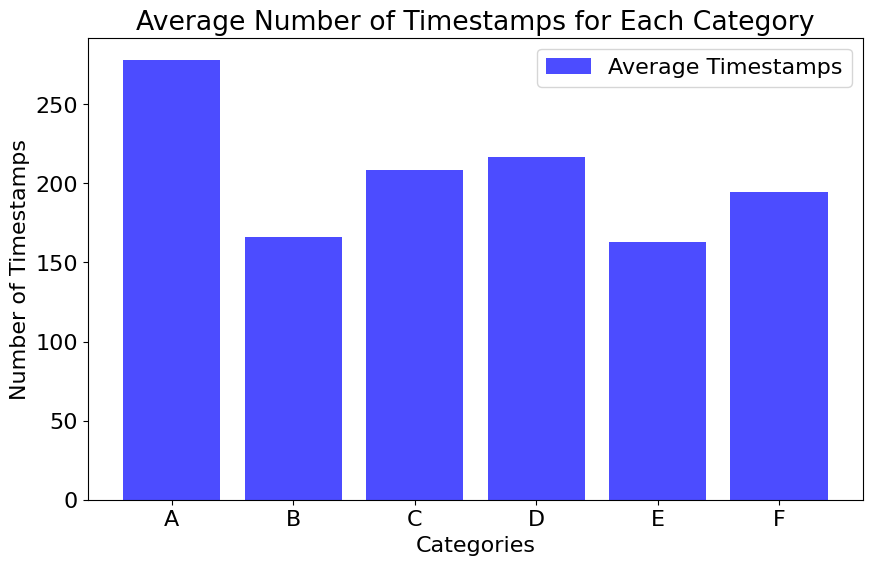

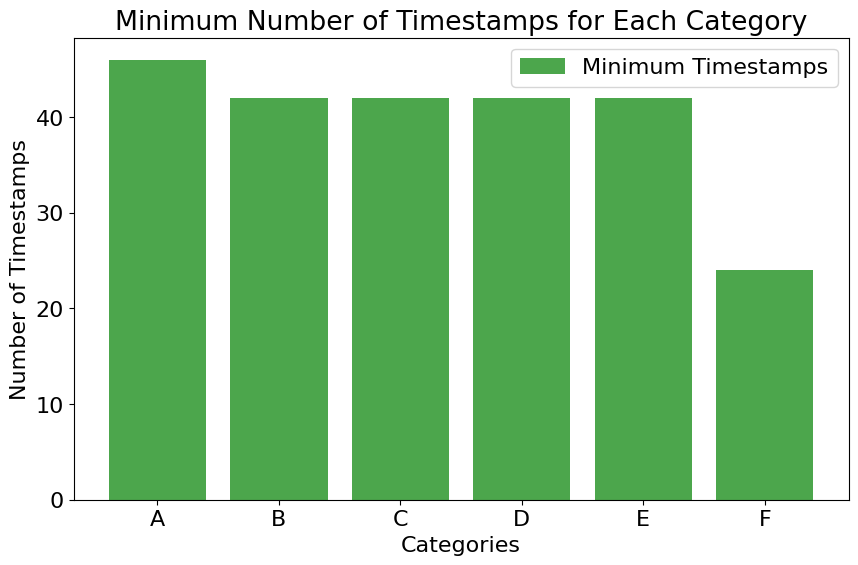

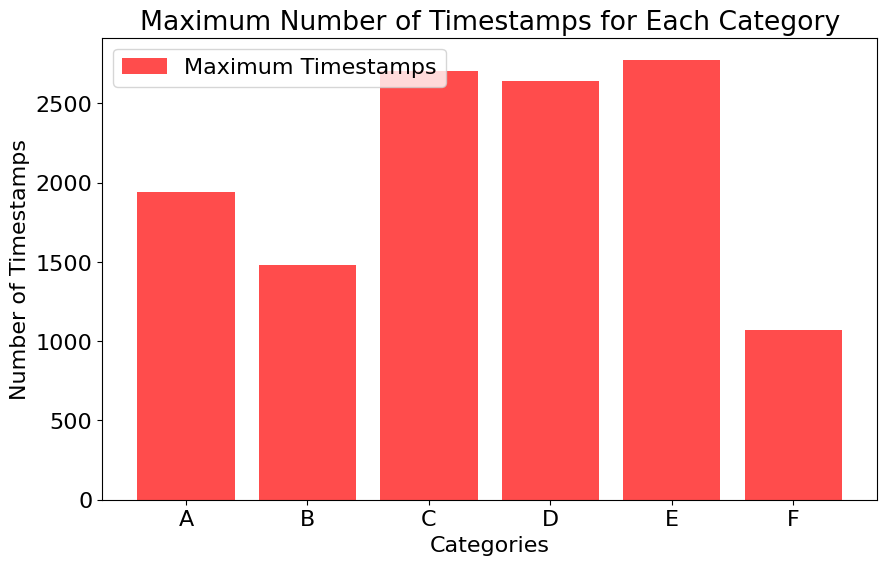

In [191]:
import matplotlib.pyplot as plt

# Extract category names and corresponding values
categories = list(average_valid_timestamps.keys())
avg_values = list(average_valid_timestamps.values())
min_values = list(min_valid_timestamps.values())
max_values = list(max_valid_timestamps.values())

# Plotting the average number of timestamps for each category
plt.figure(figsize=(10, 6))
plt.bar(categories, avg_values, color='blue', alpha=0.7, label='Average Timestamps')
plt.xlabel('Categories')
plt.ylabel('Number of Timestamps')
plt.title('Average Number of Timestamps for Each Category')
plt.legend()
plt.show()

# Plotting the minimum number of timestamps for each category
plt.figure(figsize=(10, 6))
plt.bar(categories, min_values, color='green', alpha=0.7, label='Minimum Timestamps')
plt.xlabel('Categories')
plt.ylabel('Number of Timestamps')
plt.title('Minimum Number of Timestamps for Each Category')
plt.legend()
plt.show()

# Plotting the maximum number of timestamps for each category
plt.figure(figsize=(10, 6))
plt.bar(categories, max_values, color='red', alpha=0.7, label='Maximum Timestamps')
plt.xlabel('Categories')
plt.ylabel('Number of Timestamps')
plt.title('Maximum Number of Timestamps for Each Category')
plt.legend()
plt.show()


# Plotting the number of timeseries that have at least 200 + 18 timestamps

Category A:
  Number of Time Series: 5728
  Number of Time Series with at least 218 Samples: 3831
  Average Valid Timestamps: 278.18034217877096
  Maximum Valid Timestamps: 1943
  Minimum Valid Timestamps: 46

Category B:
  Number of Time Series: 10987
  Number of Time Series with at least 218 Samples: 2837
  Average Valid Timestamps: 165.9428415400018
  Maximum Valid Timestamps: 1484
  Minimum Valid Timestamps: 42

Category C:
  Number of Time Series: 10017
  Number of Time Series with at least 218 Samples: 3666
  Average Valid Timestamps: 208.14625137266646
  Maximum Valid Timestamps: 2708
  Minimum Valid Timestamps: 42

Category D:
  Number of Time Series: 10016
  Number of Time Series with at least 218 Samples: 5346
  Average Valid Timestamps: 216.9909145367412
  Maximum Valid Timestamps: 2641
  Minimum Valid Timestamps: 42

Category E:
  Number of Time Series: 10975
  Number of Time Series with at least 218 Samples: 4081
  Average Valid Timestamps: 163.04601366742597
  Maximum Val

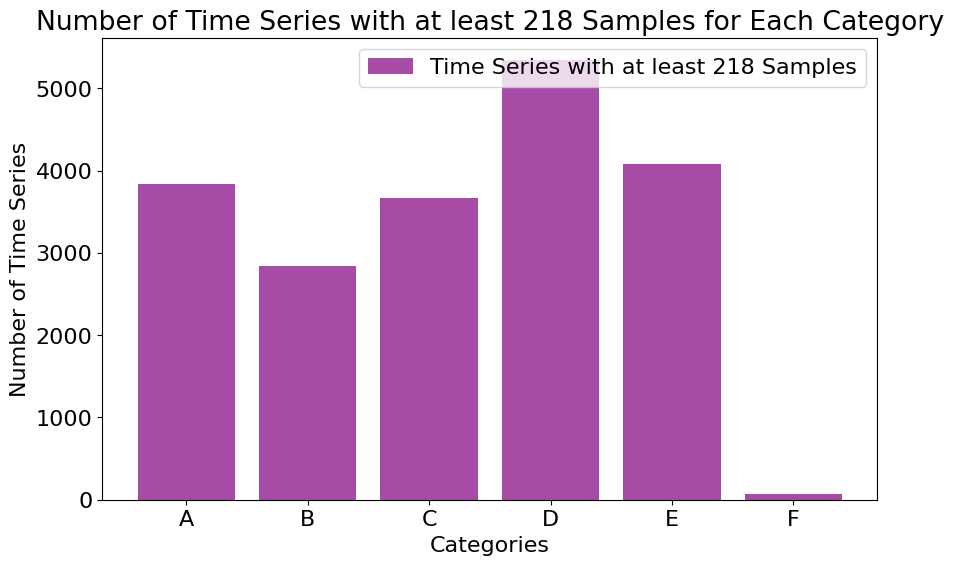

In [192]:
import matplotlib.pyplot as plt

# Initialize dictionaries to store results for each category
average_valid_timestamps = {}
max_valid_timestamps = {}
min_valid_timestamps = {}
number_of_time_series = {}
count_time_series_218 = {}

# Iterate over each category DataFrame
for category, category_df in category_dataframes.items():
    # Calculate average, maximum, and minimum valid timestamps for each category
    avg_valid = category_df['End'] - category_df['Start']   # Calculate the number of valid timestamps
    average_valid_timestamps[category] = avg_valid.mean()
    max_valid_timestamps[category] = avg_valid.max()
    min_valid_timestamps[category] = avg_valid.min()

    # Calculate the number of time series in each category
    number_of_time_series[category] = len(category_df)

    # Calculate the number of time series with at least 218 samples
    count_218 = np.sum((category_df['End'] - category_df['Start']) >= 218)
    count_time_series_218[category] = count_218

# Display the results
for category in average_valid_timestamps:
    print(f"Category {category}:")
    print(f"  Number of Time Series: {number_of_time_series[category]}")
    print(f"  Number of Time Series with at least 218 Samples: {count_time_series_218[category]}")
    print(f"  Average Valid Timestamps: {average_valid_timestamps[category]}")
    print(f"  Maximum Valid Timestamps: {max_valid_timestamps[category]}")
    print(f"  Minimum Valid Timestamps: {min_valid_timestamps[category]}")
    print()

# Plotting the number of time series with at least 218 samples for each category
plt.figure(figsize=(10, 6))
plt.bar(count_time_series_218.keys(), count_time_series_218.values(), color='purple', alpha=0.7, label='Time Series with at least 218 Samples')
plt.xlabel('Categories')
plt.ylabel('Number of Time Series')
plt.title('Number of Time Series with at least 218 Samples for Each Category')
plt.legend()
plt.show()


As we can see:
1) Categories A and F have less timeseries
2) The average number of valid timestamps is between 150 to 250, depending on the category



# PLOT THE FIRST TIME SERIE FOR EACH CATEGORY

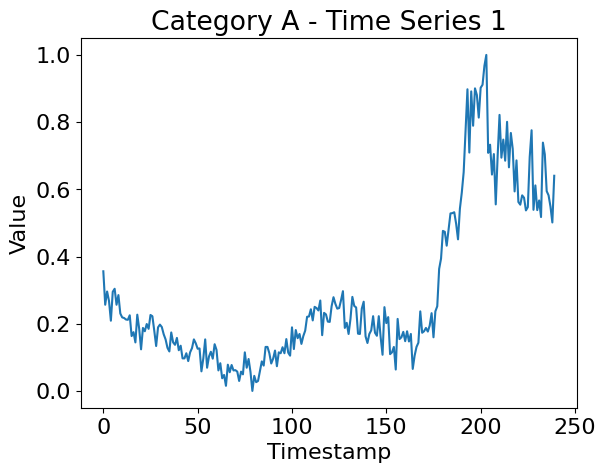

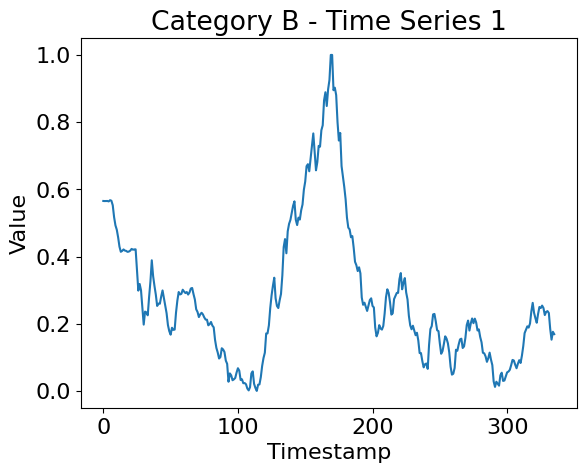

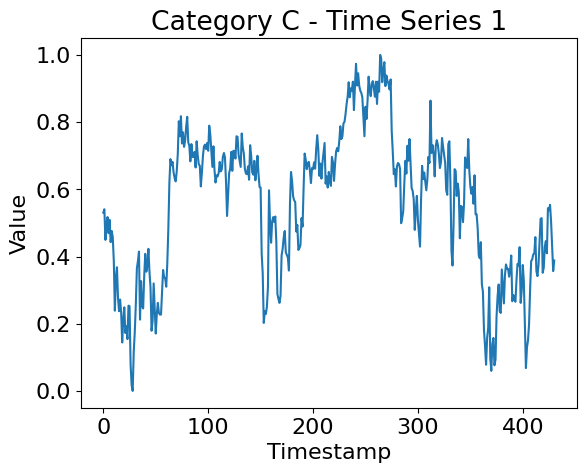

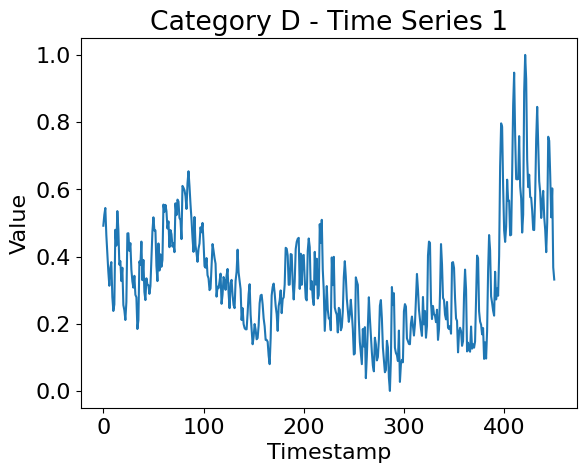

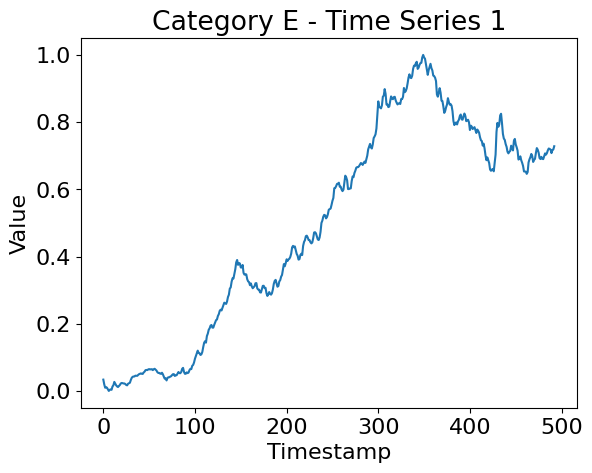

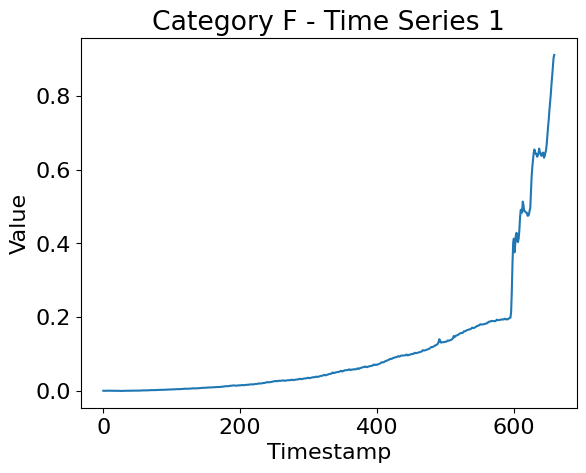

In [193]:

# Iterate over each category DataFrame
for category, category_df in category_dataframes.items():
    # Extract timestamps and data for the first time series in each category
    start, end = category_df.iloc[0]['Start'], category_df.iloc[0]['End']
    time_series_data = category_df.drop(['Start', 'End', 'Categories'], axis=1).values[0, start:end]

    # Plot the time series
    plt.figure()
    plt.plot(time_series_data)
    plt.title(f"Category {category} - Time Series 1")
    plt.xlabel("Timestamp")
    plt.ylabel("Value")
    plt.show()


# SPLIT INTO TEST/TRAIN/VAL

In [194]:
from sklearn.model_selection import train_test_split

# Control the splitting percentage (adjust as needed)
test_size = 0.2  # 20% for testing
validation_size = 0.1  # 10% for validation

# Initialize dictionaries to store train, test, and validation sets for each category
train_sets = {}
test_sets = {}
validation_sets = {}

# Iterate over each category DataFrame
for category, category_df in category_dataframes.items():
    # Extract timestamps and data for each time series in each category
    starts, ends = category_df['Start'].values, category_df['End'].values
    time_series_data = category_df.drop(['Start', 'End', 'Categories'], axis=1).values

    # Split the data into train, test, and validation sets while preserving start and end times
    train_data, test_validation_data, train_start, test_validation_start, train_end, test_validation_end = train_test_split(
        time_series_data, starts, ends, test_size=(test_size + validation_size), random_state=42
    )

    # Further split test_validation_data into test and validation sets
    test_data, validation_data, test_start, validation_start, test_end, validation_end = train_test_split(
        test_validation_data, test_validation_start, test_validation_end, test_size=validation_size/(test_size + validation_size), random_state=42
    )

    # Store the sets in dictionaries
    train_sets[category] = {'data': train_data, 'start': train_start, 'end': train_end}
    test_sets[category] = {'data': test_data, 'start': test_start, 'end': test_end}
    validation_sets[category] = {'data': validation_data, 'start': validation_start, 'end': validation_end}





# Check that the splitting is correct

In [195]:
# Initialize dictionaries to store the number of time series in train, test, and validation sets for each category
train_counts = {}
test_counts = {}
validation_counts = {}

# Iterate over each category DataFrame
for category, _ in category_dataframes.items():
    # Count the number of time series in each set
    train_count = len(train_sets[category]['data'])
    test_count = len(test_sets[category]['data'])
    validation_count = len(validation_sets[category]['data'])

    # Store the counts in dictionaries
    train_counts[category] = train_count
    test_counts[category] = test_count
    validation_counts[category] = validation_count

# Display the results
for category in train_counts:
    print(f"Category {category}:")
    print(f"  Number of Time Series in Train Set: {train_counts[category]}")
    print(f"  Number of Time Series in Test Set: {test_counts[category]}")
    print(f"  Number of Time Series in Validation Set: {validation_counts[category]}")
    print()


Category A:
  Number of Time Series in Train Set: 4009
  Number of Time Series in Test Set: 1146
  Number of Time Series in Validation Set: 573

Category B:
  Number of Time Series in Train Set: 7690
  Number of Time Series in Test Set: 2198
  Number of Time Series in Validation Set: 1099

Category C:
  Number of Time Series in Train Set: 7011
  Number of Time Series in Test Set: 2004
  Number of Time Series in Validation Set: 1002

Category D:
  Number of Time Series in Train Set: 7011
  Number of Time Series in Test Set: 2003
  Number of Time Series in Validation Set: 1002

Category E:
  Number of Time Series in Train Set: 7682
  Number of Time Series in Test Set: 2195
  Number of Time Series in Validation Set: 1098

Category F:
  Number of Time Series in Train Set: 193
  Number of Time Series in Test Set: 56
  Number of Time Series in Validation Set: 28



# PLOT THE FIRST ELEMENT OF EACH TEST/TRAIN/VAL FOR EACH CATEGORY

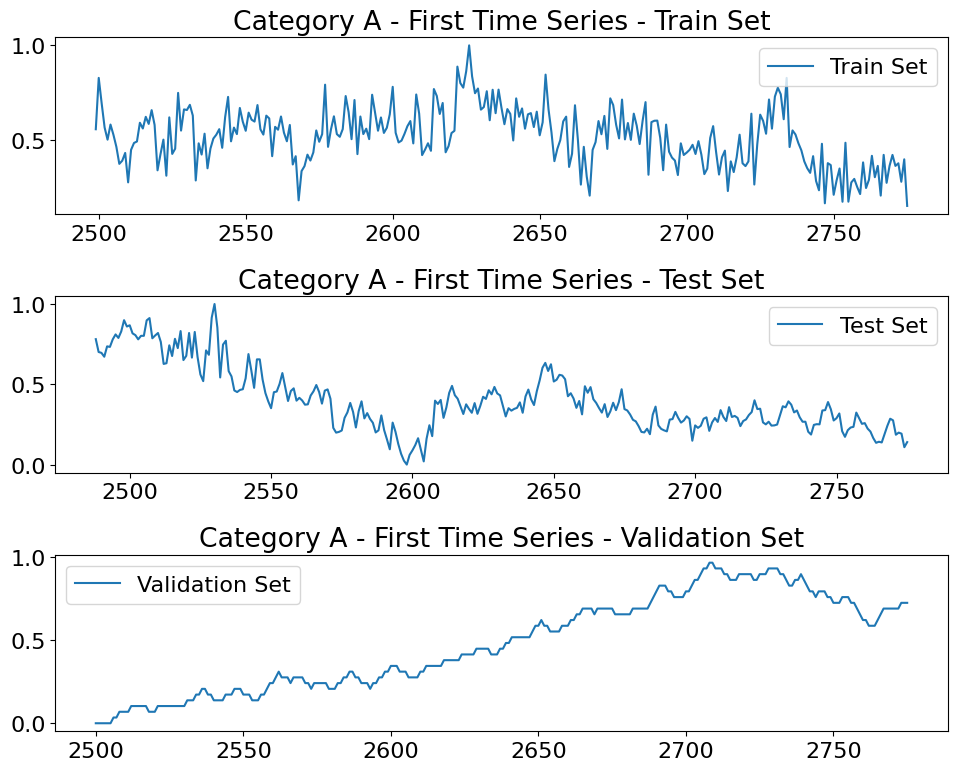

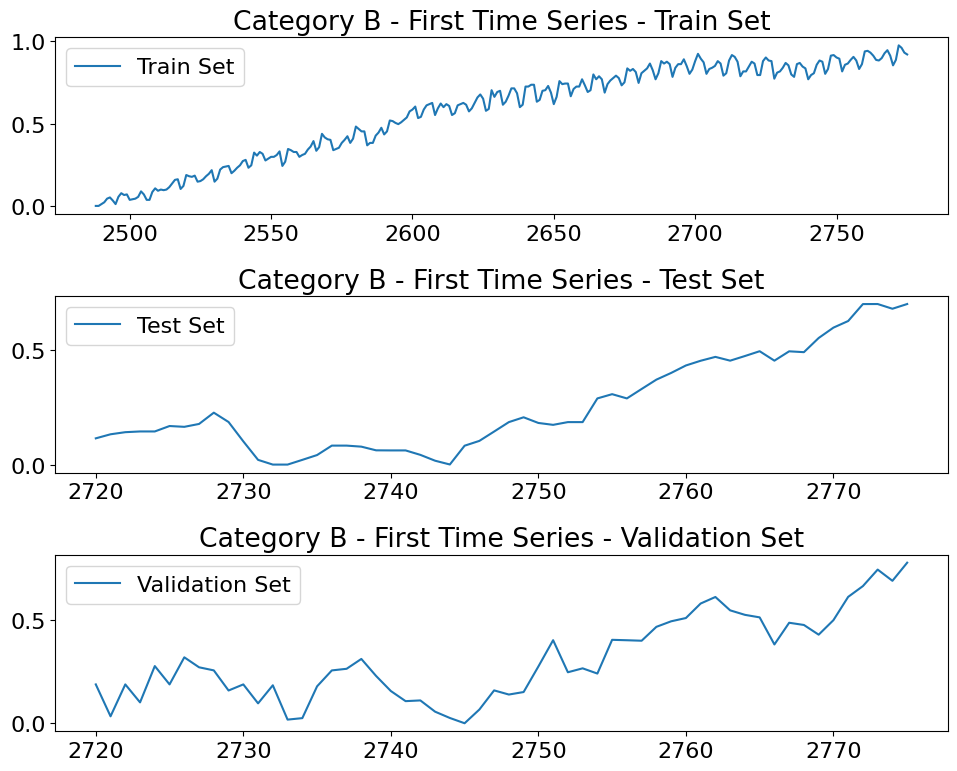

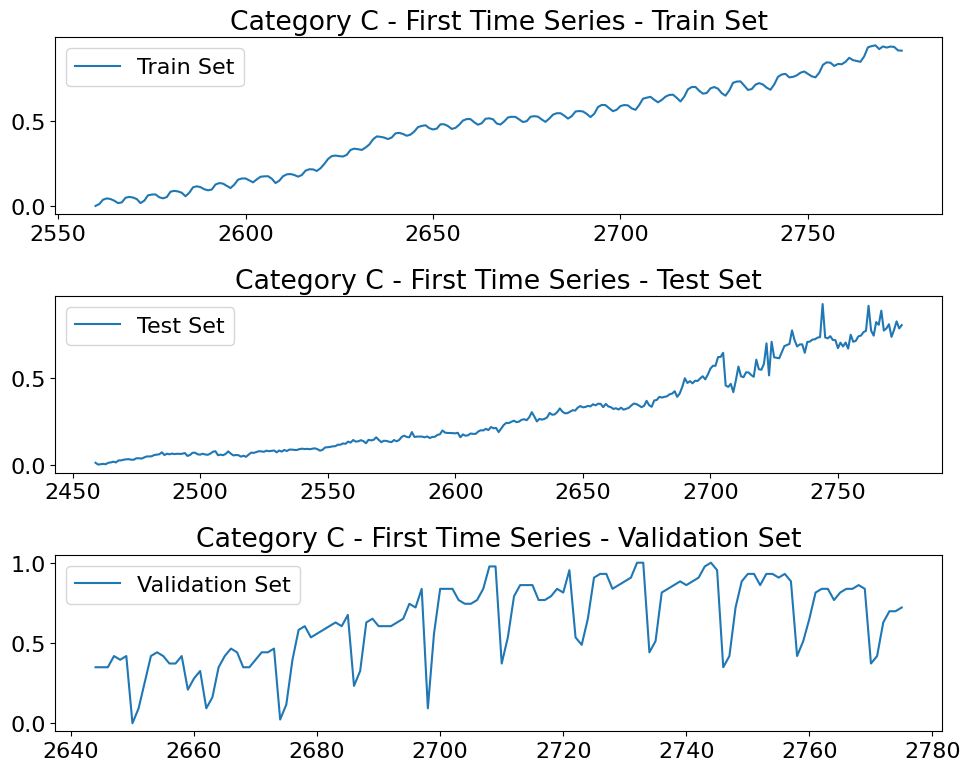

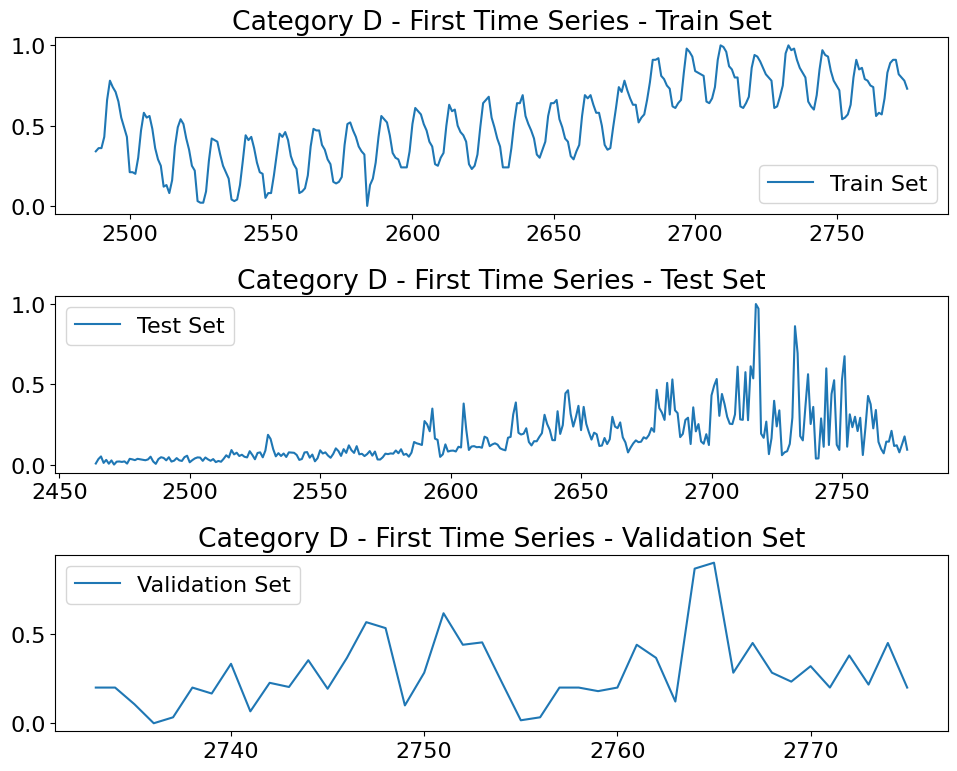

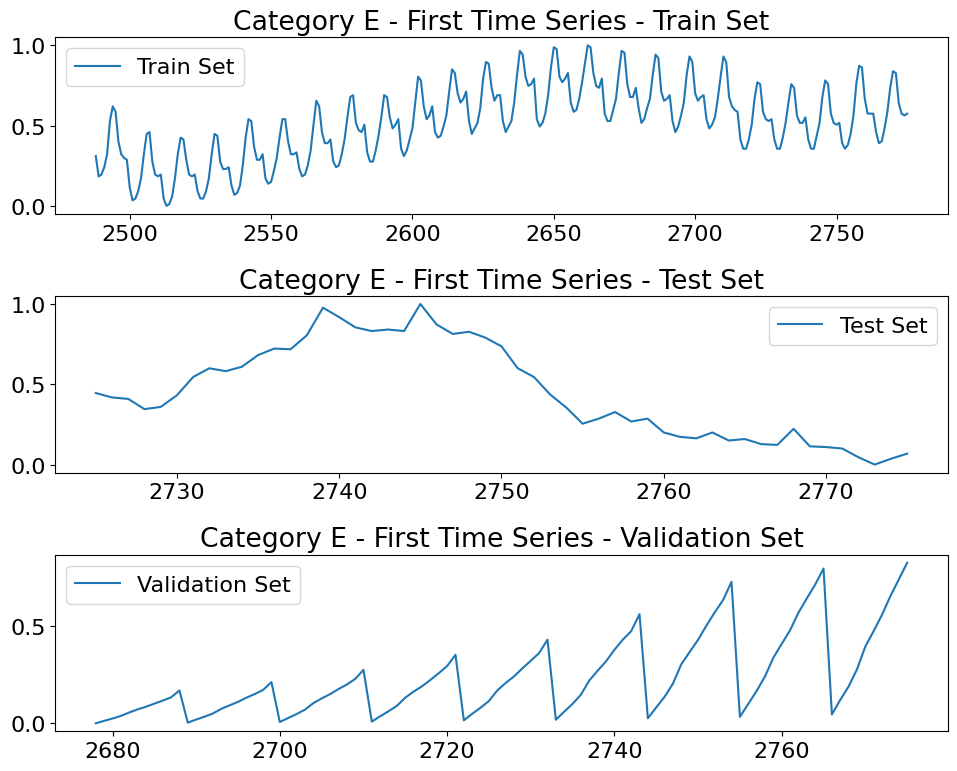

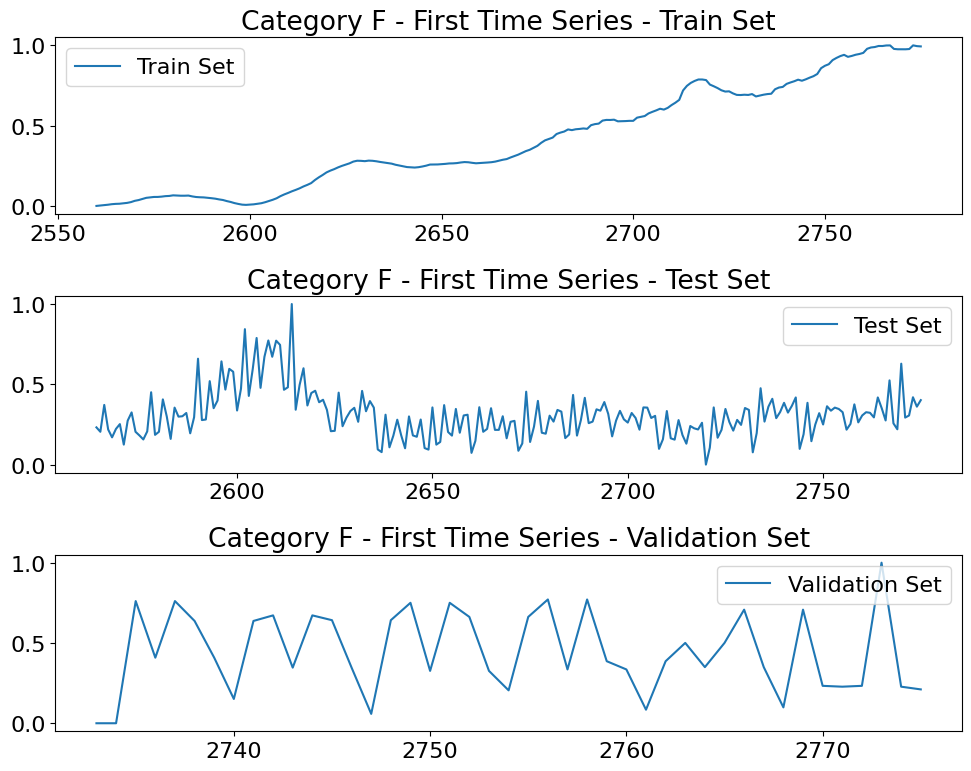

In [196]:
import matplotlib.pyplot as plt

# Iterate over each category DataFrame
for category, _ in category_dataframes.items():
    # Get the first time series data and start/end for each set
    train_start, train_end = train_sets[category]['start'][0], train_sets[category]['end'][0]
    test_start, test_end = test_sets[category]['start'][0], test_sets[category]['end'][0]
    validation_start, validation_end = validation_sets[category]['start'][0], validation_sets[category]['end'][0]

    # Plot the first time series for each set
    plt.figure(figsize=(10, 8))

    # Train Set
    train_data = train_sets[category]['data'][0, train_start:train_end]
    plt.subplot(3, 1, 1)
    plt.plot(range(train_start, train_end), train_data, label='Train Set')
    plt.title(f'Category {category} - First Time Series - Train Set')
    plt.legend()

    # Test Set
    test_data = test_sets[category]['data'][0, test_start:test_end]
    plt.subplot(3, 1, 2)
    plt.plot(range(test_start, test_end), test_data, label='Test Set')
    plt.title(f'Category {category} - First Time Series - Test Set')
    plt.legend()

    # Validation Set
    validation_data = validation_sets[category]['data'][0, validation_start:validation_end]
    plt.subplot(3, 1, 3)
    plt.plot(range(validation_start, validation_end), validation_data, label='Validation Set')
    plt.title(f'Category {category} - First Time Series - Validation Set')
    plt.legend()

    plt.tight_layout()
    plt.show()


We can see that the timeseries can be very different: some exhibit very clear trends, other clear seasonality (periodicity)

# LOOK FOR OUTLIERS in the training

In [197]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# Specify the Z-score threshold for identifying outliers
z_score_threshold = 5  # We chose 5 to better identify outliers

# Create a list to store the results
result_list = []

# Iterate over each category
for category, category_data_dict in train_sets.items():
    # Iterate over each time series in the category
    for time_series_index in range(category_data_dict['data'].shape[0]):
        # Extract time series data for the current time series
        time_series_data = category_data_dict['data'][time_series_index,
                                                       category_data_dict['start'][time_series_index]:
                                                       category_data_dict['end'][time_series_index]]

        # Calculate Z-scores for each data point in the time series
        z_scores = np.abs(stats.zscore(time_series_data))

        # Check if there is at least one outlier in the series
        has_outlier = any(z_scores > z_score_threshold)

        # Store the results in the list
        result_list.append({
            'Category': category,
            'TimeSeriesIndex': time_series_index,
            'HasOutlier': has_outlier,
        })

# Convert the list to a DataFrame
result_df = pd.DataFrame(result_list)

# Display the resulting DataFrame
print(result_df.head())



  Category  TimeSeriesIndex  HasOutlier
0        A                0       False
1        A                1       False
2        A                2       False
3        A                3       False
4        A                4       False


          sum  count  Percentage
Category                        
A          17   4009    0.424046
B         231   7690    3.003901
C         194   7011    2.767080
D         224   7011    3.194979
E         154   7682    2.004686
F           5    193    2.590674


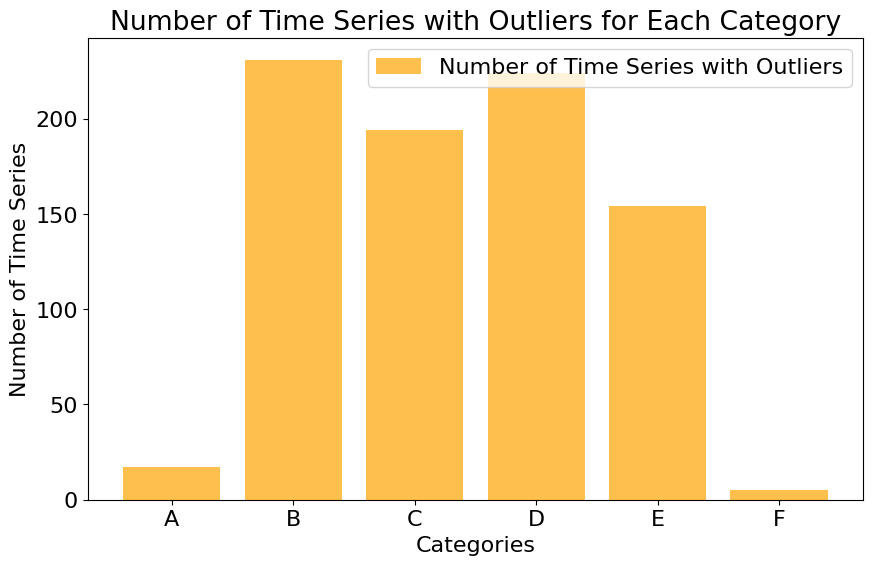

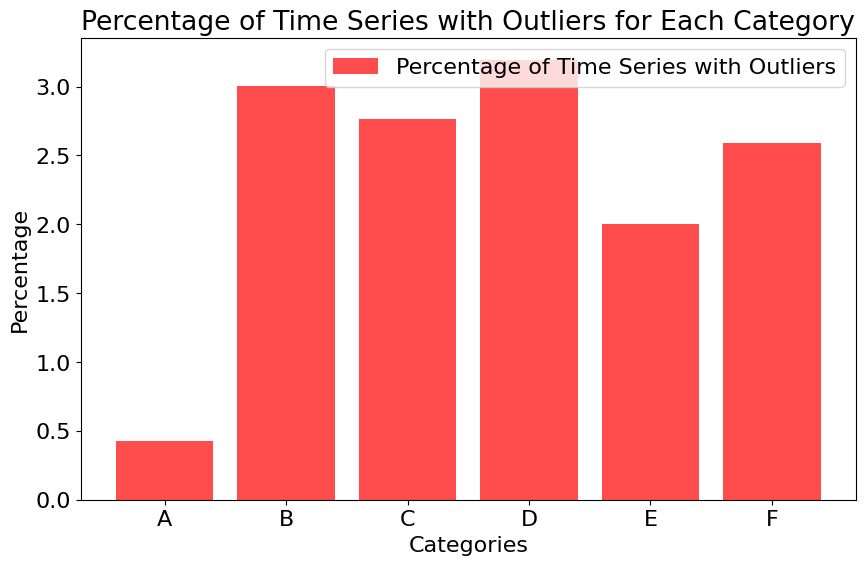

In [198]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# Specify the Z-score threshold for identifying outliers
z_score_threshold = 5  

# Create a list to store the results
result_list = []

# Iterate over each category
for category, category_data_dict in train_sets.items():
    # Iterate over each time series in the category
    for time_series_index in range(category_data_dict['data'].shape[0]):
        # Extract time series data for the current time series
        time_series_data = category_data_dict['data'][time_series_index,
                                                       category_data_dict['start'][time_series_index]:
                                                       category_data_dict['end'][time_series_index]]

        # Calculate Z-scores for each data point in the time series
        z_scores = np.abs(stats.zscore(time_series_data))

        # Check if there is at least one outlier in the series
        has_outlier = any(z_scores > z_score_threshold)

        # Store the results in the list
        result_list.append({
            'Category': category,
            'TimeSeriesIndex': time_series_index,
            'HasOutlier': has_outlier,
        })

# Convert the list to a DataFrame
result_df = pd.DataFrame(result_list)

# Calculate the number of time series with outliers and their percentage for each category
outlier_stats = result_df.groupby('Category')['HasOutlier'].agg(['sum', 'count'])
outlier_stats['Percentage'] = (outlier_stats['sum'] / outlier_stats['count']) * 100

# Display the resulting DataFrame
print(outlier_stats)

# Plotting the number of time series with outliers for each category
plt.figure(figsize=(10, 6))
plt.bar(outlier_stats.index, outlier_stats['sum'], color='orange', alpha=0.7, label='Number of Time Series with Outliers')
plt.xlabel('Categories')
plt.ylabel('Number of Time Series')
plt.title('Number of Time Series with Outliers for Each Category')
plt.legend()
plt.show()

# Plotting the percentage of time series with outliers for each category
plt.figure(figsize=(10, 6))
plt.bar(outlier_stats.index, outlier_stats['Percentage'], color='red', alpha=0.7, label='Percentage of Time Series with Outliers')
plt.xlabel('Categories')
plt.ylabel('Percentage')
plt.title('Percentage of Time Series with Outliers for Each Category')
plt.legend()
plt.show()


# Plot a random time series which has an outlier

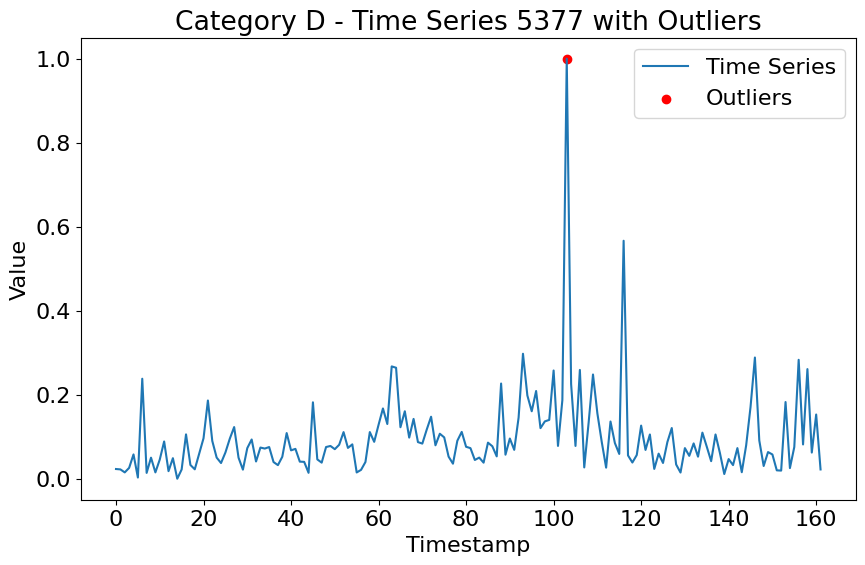

In [199]:
# Plot a random time series with an outlier (if found)
random_outlier_row = result_df[result_df['HasOutlier']].sample(1).iloc[0]
category = random_outlier_row['Category']
time_series_index = random_outlier_row['TimeSeriesIndex']


# Extract time series data for the current time series
time_series_data = train_sets[category]['data'][time_series_index,
                                              train_sets[category]['start'][time_series_index]:
                                              train_sets[category]['end'][time_series_index]]

# Calculate Z-scores for each data point in the time series
z_scores = np.abs(stats.zscore(time_series_data))

# Identify indices of outliers based on the Z-scores
outlier_indices = np.where(z_scores > z_score_threshold)[0]

# Plot the time series with outliers marked
plt.figure(figsize=(10, 6))
plt.plot(time_series_data, label='Time Series')
plt.scatter(outlier_indices, time_series_data[outlier_indices], color='red', label='Outliers')
plt.title(f'Category {category} - Time Series {time_series_index} with Outliers')
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend()
plt.show()


# Show the negative effects of robust scaling

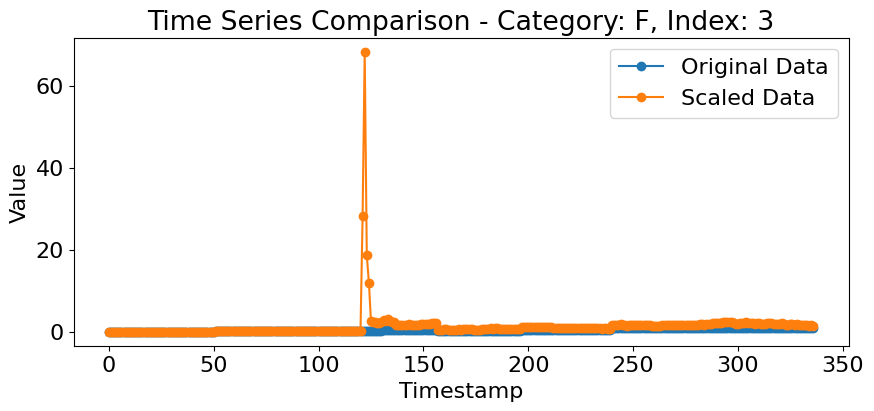

In [232]:

from sklearn.preprocessing import RobustScaler

# Initialize RobustScaler
robust_scaler = RobustScaler(with_centering=False, with_scaling=True, quantile_range=(25.0, 75.0))
# Get the unique categories
unique_categories = np.unique(categories)

# Initialize a dictionary to store the scaled training sets
scaled_train_sets = {}

# Iterate over each unique category
for category in unique_categories:
    # Extract data, start, and end times
    data_dict = train_sets[category]
    data_robust = data_dict['data']

    # Apply robust scaling to the training data
    scaled_train_data = robust_scaler.fit_transform(data_robust)

    # Store the scaled training data in the dictionary
    scaled_train_sets[category] = {'data': scaled_train_data, 'start': data_dict['start'], 'end': data_dict['end']}
    
# Now, scaled_train_sets contains the scaled training data for each category
import matplotlib.pyplot as plt

# Select a category and a time series index for comparison
selected_category = unique_categories[5]  
time_series_index = 3  

# Extract original and scaled time series data
original_data_dict = train_sets[selected_category]
scaled_data_dict = scaled_train_sets[selected_category]

# Extract relevant timestamp window
start_timestamp = original_data_dict['start'][time_series_index]
end_timestamp = original_data_dict['end'][time_series_index]

original_data = original_data_dict['data'][time_series_index, start_timestamp:end_timestamp]
scaled_data = scaled_data_dict['data'][time_series_index, start_timestamp:end_timestamp]

# Plot the original and scaled time series
plt.figure(figsize=(10, 4))
plt.plot(original_data, label='Original Data', marker='o')
plt.plot(scaled_data, label='Scaled Data', marker='o')
plt.title(f'Time Series Comparison - Category: {selected_category}, Index: {time_series_index}')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()


# Manually removing outliers from the time series

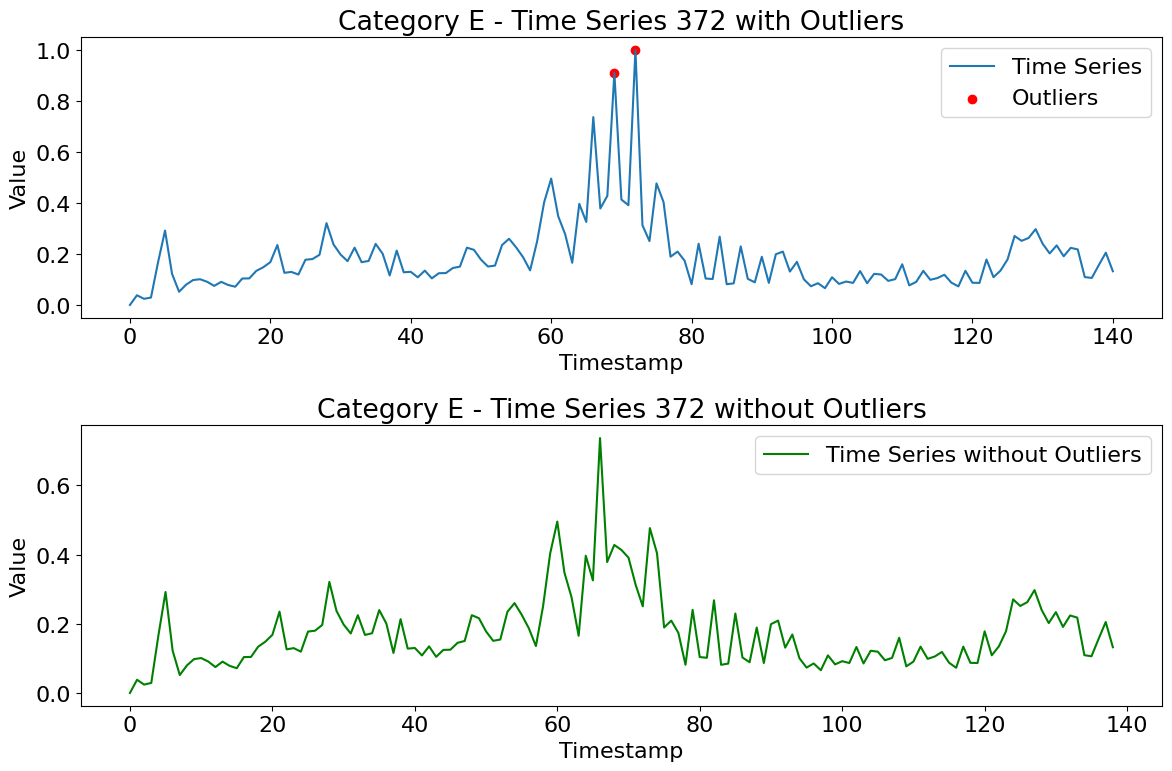

5


In [200]:
# Find a random row with an outlier
random_outlier_row = result_df[result_df['HasOutlier']].sample(1).iloc[0]
category = random_outlier_row['Category']
time_series_index = random_outlier_row['TimeSeriesIndex']

# Extract time series data for the current time series
time_series_data = train_sets[category]['data'][time_series_index,
                                              train_sets[category]['start'][time_series_index]:
                                              train_sets[category]['end'][time_series_index]]

# Calculate Z-scores for each data point in the time series
z_scores = np.abs(stats.zscore(time_series_data))

# Identify indices of outliers based on the Z-scores
outlier_indices = np.where(z_scores > z_score_threshold)[0]

# Plot the original time series with outliers marked
plt.figure(figsize=(12, 8))

# Subplot 1: Original time series with outliers marked
plt.subplot(2, 1, 1)
plt.plot(time_series_data, label='Time Series')
plt.scatter(outlier_indices, time_series_data[outlier_indices], color='red', label='Outliers')
plt.title(f'Category {category} - Time Series {time_series_index} with Outliers')
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend()

# Subplot 2: Time series with outliers removed
time_series_data_no_outliers = np.delete(time_series_data, outlier_indices)
plt.subplot(2, 1, 2)
plt.plot(time_series_data_no_outliers, label='Time Series without Outliers', color='green')
plt.title(f'Category {category} - Time Series {time_series_index} without Outliers')
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend()

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

print(z_score_threshold)


# CORRELATION FUNCTION: Finding Trends and Seasonality

Let's do a complete analysis of the autocorrelation of our data
If the autocorrelation takes many timeshifts to go to zero, this is an indicator of the presence of trends in the signal, which means that past observations within that timewindoiw are informative about the future. On the other side, relying too much on autocorrelation can lead to overfitting, since the model won't learn to predict also based on signal that are less correlated

If a strong peak (0.5 or above) appears again after some time, this is instead an indicator of seasonality( think of le maree che ritornano ogni tot).

Positive autocorrelation means that the increase observed in a time interval leads to a proportionate increase in the lagged time interval.

Conversely, negative autocorrelation represents that the increase observed in a time interval leads to a proportionate decrease in the lagged time interval. By plotting the observations with a regression line, it shows that a positive error will be followed by a negative one and vice versa.

In [201]:
# Get the unique categories
unique_categories = np.unique(categories)

For each timeseries I want to understand:
1) If the signal may potentially show some seasonality
2) If the signal may potentially show some trends

# PLOT THE AUTOCORRELATION AND LOOK FOR TREND AND SEASONALITY

Window_trend: 53
There is a local peak equal to or greater than 0.5, indicating potential seasonality.
estimated period: 60
[60 72]


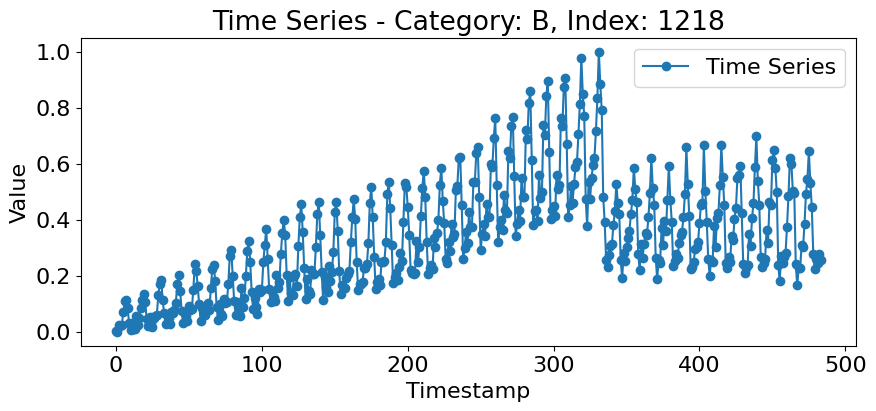

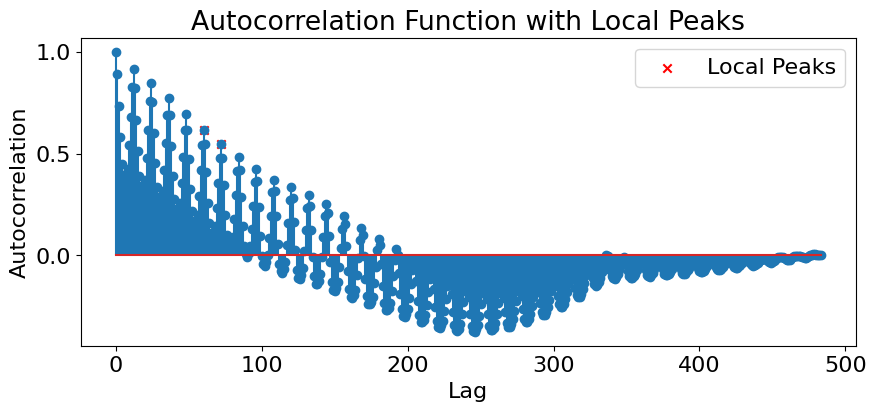

In [202]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

#a good thing to show is 1, 1218

# Select a category and a time series index for comparison
selected_category = unique_categories[1]  
time_series_index = 1218  

# Extract scaled time series data
scaled_data_dict = train_sets[selected_category]

# Extract relevant timestamp window
start_timestamp = scaled_data_dict['start'][time_series_index]
end_timestamp = scaled_data_dict['end'][time_series_index]

scaled_data_temp = scaled_data_dict['data'][time_series_index, start_timestamp:end_timestamp]

# Calculate the autocorrelation function
acf_result = sm.tsa.acf(scaled_data_temp, nlags=len(scaled_data_temp))

# Find the first timestamp where autocorrelation drops to zero
first_zero_lag = np.argmax(acf_result <= 0.2)

# Check if the autocorrelation never goes to zero
if first_zero_lag == 0:
    print("Autocorrelation never goes to zero.")
    first_zero_lag = len(scaled_data_temp)
    

# Print the first timestamp where autocorrelation drops to zero
print(f"Window_trend: {first_zero_lag}")

# Find local peaks in the autocorrelation function
peaks, _ = find_peaks(acf_result[first_zero_lag:], height=0.5)


# Get the values and positions of the local peaks
peak_values = acf_result[first_zero_lag + peaks]
peak_positions = peaks + first_zero_lag

# Check if any local peak value is equal to or greater than 0.5
if any(peak_values >= 0.5):
    print("There is a local peak equal to or greater than 0.5, indicating potential seasonality.")
    period = peak_positions[0] 
    print(f"estimated period: {period}")
    print(peak_positions)
else:
    print("No significant local peaks equal to or greater than 0.5 found, low chance of seasonality.")

# Plot the timeseries
plt.figure(figsize=(10, 4))
plt.plot(scaled_data_temp, label='Time Series', marker='o')
plt.title(f'Time Series - Category: {selected_category}, Index: {time_series_index}')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot the autocorrelation function with local peaks marked
plt.figure(figsize=(10, 4))
plt.stem(acf_result)
plt.scatter(peak_positions, peak_values, color='red', marker='x', label='Local Peaks')
plt.title('Autocorrelation Function with Local Peaks')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.show()




# IMPROVED VERSION: SMALLER WINDOW, MORE PEAKS

Window_trend: 53
[0.91689736 0.84409669 0.77208566 0.69244524 0.61749166 0.5480608 ]
[12 24 36 48 60 72]
There is a local peak equal to or greater than 0.5, indicating potential seasonality.
estimated period: 12
[12 24 36 48 60 72]


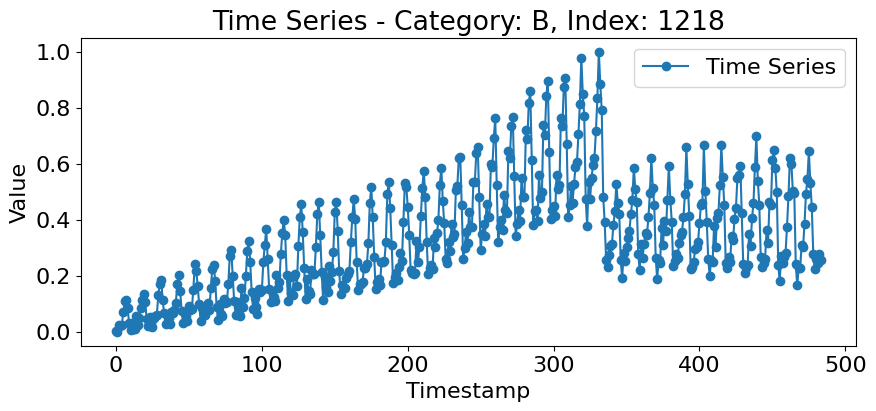

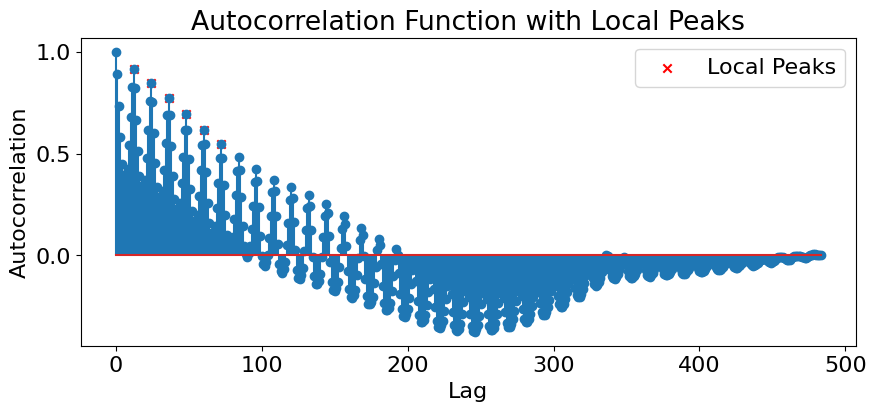

In [203]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

#a good thing to show is 1, 1218

# Select a category and a time series index for comparison
selected_category = unique_categories[1]  
time_series_index = 1218  

# Extract scaled time series data
scaled_data_dict = train_sets[selected_category]

# Extract relevant timestamp window
start_timestamp = scaled_data_dict['start'][time_series_index]
end_timestamp = scaled_data_dict['end'][time_series_index]

scaled_data_temp = scaled_data_dict['data'][time_series_index, start_timestamp:end_timestamp]

# Calculate the autocorrelation function
acf_result = sm.tsa.acf(scaled_data_temp, nlags=len(scaled_data_temp))

# Find the first timestamp where autocorrelation drops to zero
first_zero_lag = np.argmax(acf_result <= 0.2)

# Check if the autocorrelation never goes to zero
if first_zero_lag == 0:
    print("Autocorrelation never goes to zero.")
    first_zero_lag = len(scaled_data_temp)
    

# Print the first timestamp where autocorrelation drops to zero
print(f"Window_trend: {first_zero_lag}")

# Find local peaks in the autocorrelation function
#the distance was set to 10 after a seasonality of 12 emerged in the previous tests
peaks, _ = find_peaks(acf_result, height=0.5, distance=10)


# Get the values and positions of the local peaks
peak_values = acf_result[peaks]
peak_positions = peaks
print(peak_values)
print(peak_positions)
# Check if any local peak value is equal to or greater than 0.5
if any(peak_values >= 0.5):
    print("There is a local peak equal to or greater than 0.5, indicating potential seasonality.")
    period = peak_positions[0] 
    print(f"estimated period: {period}")
    print(peak_positions)
else:
    print("No significant local peaks equal to or greater than 0.5 found, low chance of seasonality.")

# Plot the timeseries
plt.figure(figsize=(10, 4))
plt.plot(scaled_data_temp, label='Time Series', marker='o')
plt.title(f'Time Series - Category: {selected_category}, Index: {time_series_index}')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot the autocorrelation function with local peaks marked
plt.figure(figsize=(10, 4))
plt.stem(acf_result)
plt.scatter(peak_positions, peak_values, color='red', marker='x', label='Local Peaks')
plt.title('Autocorrelation Function with Local Peaks')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.show()

# SHOW HOW A TIME SERIE CAN BE DECOMPOSED IN SEASON + TREND + RESIDUAL

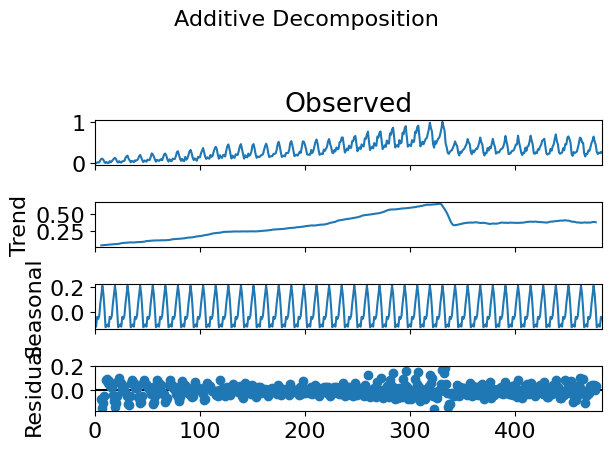

In [204]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


# Select a category and a time series index for comparison
selected_category = unique_categories[1]  # You can choose any category
time_series_index = 1218  # You can choose any time series index

# Extract scaled time series data
scaled_data_dict = train_sets[selected_category]

# Extract relevant timestamp window
start_timestamp = scaled_data_dict['start'][time_series_index]
end_timestamp = scaled_data_dict['end'][time_series_index]

scaled_data_temp = scaled_data_dict['data'][time_series_index, start_timestamp:end_timestamp]


# Additive Decomposition
additive_decomposition = seasonal_decompose(scaled_data_temp, model='additive', period=12)



additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

# Find the first zero lags statistics

In [205]:
import statsmodels.api as sm
import numpy as np

# Initialize lists to store results
avg_first_zero_lag_list = []
max_first_zero_lag_list = []
min_first_zero_lag_list = []
# Iterate over each unique category
for category in unique_categories:

    category_data_dict = train_sets[category]

    # Initialize lists to store first_zero_lag for each time series in the category
    first_zero_lag_values = []
    period_values = []
    seasonality_count = 0
    
    # Iterate over each time series in the category
    for time_series_index in range(category_data_dict['data'].shape[0]):
        
        scaled_data_temp = category_data_dict['data'][time_series_index,
                                                      category_data_dict['start'][time_series_index]:
                                                      category_data_dict['end'][time_series_index]]

        # Calculate the autocorrelation function
        acf_result = sm.tsa.acf(scaled_data_temp, nlags=len(scaled_data_temp)-1)

        # Find the first timestamp where autocorrelation drops to zero
        first_zero_lag = np.argmax(acf_result <= 0.2)
        
         # Find local peaks in the autocorrelation function
        peaks, _ = find_peaks(acf_result[first_zero_lag:], height=0.5)

         # Get the values of local peaks
        peak_values = acf_result[first_zero_lag + peaks]
        peak_positions = peaks + first_zero_lag
        
        period=0
        # Check if any local peak value is equal to or greater than 0.5
        if any(peak_values >= 0.5):
            
            seasonality_count += 1
            period = peak_positions[0]
           # print(f"possible seasonality in {time_series_index},{category} with period{period} ")

        # Append to the list
        first_zero_lag_values.append(first_zero_lag)
        period_values.append(period)
        
    # Calculate average, maximum, and minimum for the category
    avg_first_zero_lag = np.mean(first_zero_lag_values)
    max_first_zero_lag = np.max(first_zero_lag_values)
    min_first_zero_lag = np.min(first_zero_lag_values)
    avg_period = np.mean(period_values)
    
    # Append to the overall lists
    avg_first_zero_lag_list.append(avg_first_zero_lag)
    max_first_zero_lag_list.append(max_first_zero_lag)
    min_first_zero_lag_list.append(min_first_zero_lag)

    # Print results for the current category
    print(f"Category: {category}")
    print(f"Average First Zero Lag: {avg_first_zero_lag}")
    print(f"Maximum First Zero Lag: {max_first_zero_lag}")
    print(f"Minimum First Zero Lag: {min_first_zero_lag}")
    print(f"seasonality_count: {seasonality_count}")
    print(f"Average Period: {avg_period}")
    print("\n")

# Print overall results
print("Overall Results:")
print(f"Average First Zero Lag across Categories: {np.mean(avg_first_zero_lag_list)}")
print(f"Maximum First Zero Lag across Categories: {np.max(max_first_zero_lag_list)}")
print(f"Minimum First Zero Lag across Categories: {np.min(min_first_zero_lag_list)}")


Category: A
Average First Zero Lag: 51.58568221501621
Maximum First Zero Lag: 256
Minimum First Zero Lag: 1
seasonality_count: 228
Average Period: 1.0212022948366175


Category: B
Average First Zero Lag: 30.78751625487646
Maximum First Zero Lag: 317
Minimum First Zero Lag: 1
seasonality_count: 250
Average Period: 0.4396618985695709


Category: C
Average First Zero Lag: 37.49992868349736
Maximum First Zero Lag: 306
Minimum First Zero Lag: 1
seasonality_count: 570
Average Period: 1.023391812865497


Category: D
Average First Zero Lag: 41.999144201968335
Maximum First Zero Lag: 402
Minimum First Zero Lag: 1
seasonality_count: 317
Average Period: 0.9378120096990443


Category: E
Average First Zero Lag: 31.3926060921635
Maximum First Zero Lag: 258
Minimum First Zero Lag: 1
seasonality_count: 335
Average Period: 0.6584222858630565


Category: F
Average First Zero Lag: 35.78238341968912
Maximum First Zero Lag: 171
Minimum First Zero Lag: 1
seasonality_count: 31
Average Period: 3.2694300518134

# More realistic values to set the window

In [206]:
import statsmodels.api as sm
import numpy as np

# Initialize lists to store results
avg_first_zero_lag_list = []
max_first_zero_lag_list = []
min_first_zero_lag_list = []
# Iterate over each unique category
for category in unique_categories:

    category_data_dict = train_sets[category]

    # Initialize lists to store first_zero_lag for each time series in the category
    first_zero_lag_values = []
    period_values = []
    seasonality_count = 0
    
    # Iterate over each time series in the category
    for time_series_index in range(category_data_dict['data'].shape[0]):
        
        scaled_data_temp = category_data_dict['data'][time_series_index,
                                                      category_data_dict['start'][time_series_index]:
                                                      category_data_dict['end'][time_series_index]]

        # Calculate the autocorrelation function
        acf_result = sm.tsa.acf(scaled_data_temp, nlags=len(scaled_data_temp)-1)

        # Find the first timestamp where autocorrelation drops to zero
        first_zero_lag = np.argmax(acf_result <= 0.2)
        
         # Find local peaks in the autocorrelation function
        peaks, _ = find_peaks(acf_result, height=0.5, distance=10)

         # Get the values of local peaks
        peak_values = acf_result[peaks]
        peak_positions = peaks
        
        period=0
        # Check if any local peak value is equal to or greater than 0.5
        if any(peak_values >= 0.5):
            
            seasonality_count += 1
            period = peak_positions[0]
            #print(f"possible seasonality in {time_series_index},{category} with period{period} ")

        # Append to the list
        first_zero_lag_values.append(first_zero_lag)
        period_values.append(period)
        
    # Calculate average, maximum, and minimum for the category
    avg_first_zero_lag = np.mean(first_zero_lag_values)
    max_first_zero_lag = np.max(first_zero_lag_values)
    min_first_zero_lag = np.min(first_zero_lag_values)
    avg_period = np.mean(period_values)
    
    # Append to the overall lists
    avg_first_zero_lag_list.append(avg_first_zero_lag)
    max_first_zero_lag_list.append(max_first_zero_lag)
    min_first_zero_lag_list.append(min_first_zero_lag)

    # Print results for the current category
    print(f"Category: {category}")
    print(f"Average First Zero Lag: {avg_first_zero_lag}")
    print(f"Maximum First Zero Lag: {max_first_zero_lag}")
    print(f"Minimum First Zero Lag: {min_first_zero_lag}")
    #print(f"seasonality_count: {seasonality_count}")
    #print(f"Average Period: {avg_period}")
    print("\n")

# Print overall results
print("Overall Results:")
print(f"Average First Zero Lag across Categories: {np.mean(avg_first_zero_lag_list)}")
print(f"Maximum First Zero Lag across Categories: {np.max(max_first_zero_lag_list)}")
print(f"Minimum First Zero Lag across Categories: {np.min(min_first_zero_lag_list)}")


Category: A
Average First Zero Lag: 51.58568221501621
Maximum First Zero Lag: 256
Minimum First Zero Lag: 1


Category: B
Average First Zero Lag: 30.78751625487646
Maximum First Zero Lag: 317
Minimum First Zero Lag: 1


Category: C
Average First Zero Lag: 37.49992868349736
Maximum First Zero Lag: 306
Minimum First Zero Lag: 1


Category: D
Average First Zero Lag: 41.999144201968335
Maximum First Zero Lag: 402
Minimum First Zero Lag: 1


Category: E
Average First Zero Lag: 31.3926060921635
Maximum First Zero Lag: 258
Minimum First Zero Lag: 1


Category: F
Average First Zero Lag: 35.78238341968912
Maximum First Zero Lag: 171
Minimum First Zero Lag: 1


Overall Results:
Average First Zero Lag across Categories: 38.1745434778685
Maximum First Zero Lag across Categories: 402
Minimum First Zero Lag across Categories: 1


# REMOVING TRENDS and PLOTTING THE RESULTING AUTOCORRELATION

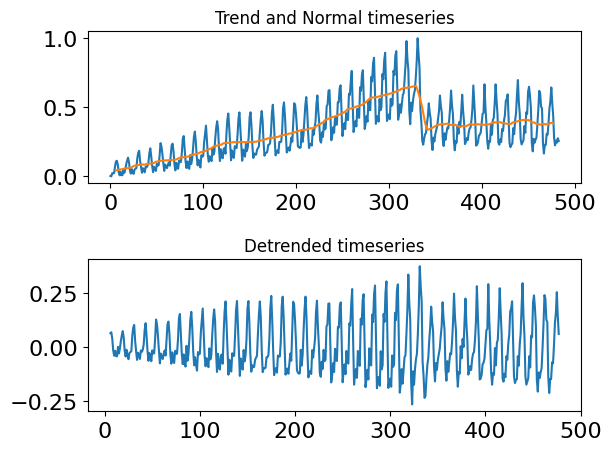

In [207]:
# Using statmodels: Subtracting the Trend Component
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


# Select a category and a time series index for comparison
selected_category = unique_categories[1]  # You can choose any category
time_series_index = 1218  # You can choose any time series index

# Extract scaled time series data
scaled_data_dict = train_sets[selected_category]

# Extract relevant timestamp window
start_timestamp = scaled_data_dict['start'][time_series_index]
end_timestamp = scaled_data_dict['end'][time_series_index]

scaled_data_temp = scaled_data_dict['data'][time_series_index, start_timestamp:end_timestamp]


result_mul = seasonal_decompose(scaled_data_temp, model='additive', period=12)
detrended = scaled_data_temp - result_mul.trend


# Create a 2x1 grid for plots
plt.subplot(2, 1, 1)
plt.plot(scaled_data_temp)
plt.title('Normal timeseries', fontsize=12)

plt.subplot(2, 1, 1)
plt.plot(result_mul.trend)
plt.title('Trend and Normal timeseries', fontsize=12)

plt.subplot(2, 1, 2)
plt.plot(detrended)
plt.title('Detrended timeseries', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


Detrended series contains NaN or Inf values. Check your data.
Window_trend: 3
There is a local peak equal to or greater than 0.5, indicating potential seasonality.
estimated period: 12
[ 12  24  36  48  60  72  84  96 108 120 132 144 156 168 180]


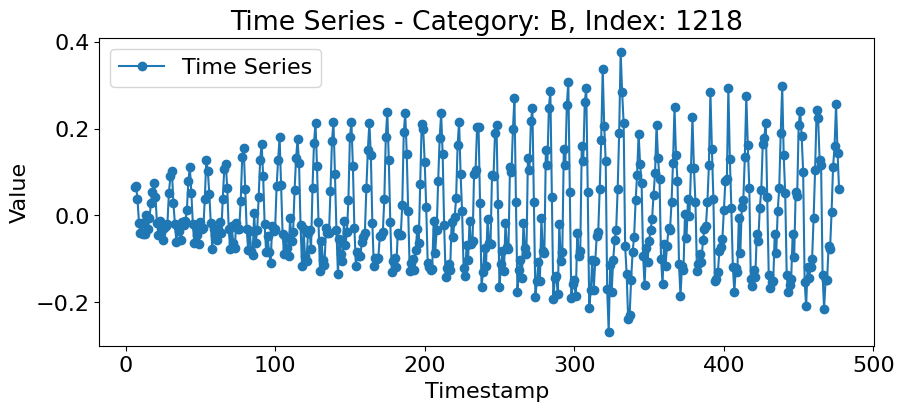

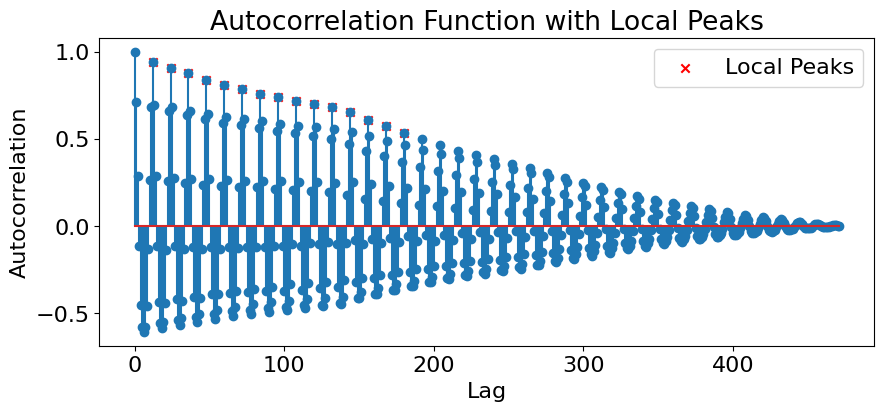

In [208]:
# Check for NaN or Inf values in the detrended series
if np.isnan(detrended).any() or np.isinf(detrended).any():
    print("Detrended series contains NaN or Inf values. Check your data.")
else:
    # Check the length of the detrended series
    print("Length of detrended series:", len(detrended))
#print(detrended)

detrended_cleaned = detrended[~np.isnan(detrended)]

#print(detrended_cleaned)
    
# Calculate the autocorrelation function
acf_result = sm.tsa.acf(detrended_cleaned, nlags=len(detrended_cleaned)-1)


# Find the first timestamp where autocorrelation drops to zero
first_zero_lag = np.argmax(acf_result <= 0)

# Check if the autocorrelation never goes to zero
if first_zero_lag == 0:
    print("Autocorrelation never goes to zero.")
    first_zero_lag = len(detrended)
    

# Print the first timestamp where autocorrelation drops to zero
print(f"Window_trend: {first_zero_lag}")

# Find local peaks in the autocorrelation function
peaks, _ = find_peaks(acf_result[first_zero_lag:], height=0.5)


# Get the values and positions of the local peaks
peak_values = acf_result[first_zero_lag + peaks]
peak_positions = peaks + first_zero_lag

# Check if any local peak value is equal to or greater than 0.5
if any(peak_values >= 0.5):
    print("There is a local peak equal to or greater than 0.5, indicating potential seasonality.")
    period = peak_positions[0] 
    print(f"estimated period: {period}")
    print(peak_positions)
else:
    print("No significant local peaks equal to or greater than 0.5 found, low chance of seasonality.")

# Plot the timeseries
plt.figure(figsize=(10, 4))
plt.plot(detrended, label='Time Series', marker='o')
plt.title(f'Time Series - Category: {selected_category}, Index: {time_series_index}')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot the autocorrelation function with local peaks marked
plt.figure(figsize=(10, 4))
plt.stem(acf_result)
plt.scatter(peak_positions, peak_values, color='red', marker='x', label='Local Peaks')

plt.title('Autocorrelation Function with Local Peaks')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.show()

# Final DATA analysis 

In [209]:
# Get the unique categories
unique_categories = np.unique(categories)

# FOR EACH TIME SERIE FIND THE WINDOW, THE PERIODICITY. THEN REMOVE THE TREND AND COMPUTE THE PERIODICITY AGAIN TO REMOVE FALSE PERIODICITIES 

In [210]:
# Create a list to store the results
result_list = []
# Iterate over each unique category
for category in unique_categories:

    category_data_dict = train_sets[category]
    
    # Iterate over each time series in the category
    for time_series_index in range(category_data_dict['data'].shape[0]):
        
        scaled_data_temp = category_data_dict['data'][time_series_index,
                                                      category_data_dict['start'][time_series_index]:
                                                      category_data_dict['end'][time_series_index]]


        # Estimate original period
        acf_result = sm.tsa.acf(scaled_data_temp, nlags=len(scaled_data_temp)-1)
        first_zero_lag = np.argmax(acf_result <= 0.2)
        if first_zero_lag == 0:
            original_period = 0  # Default period if no period is found
        else:
            peaks, _ = find_peaks(acf_result, height=0.5, distance=10)
            if any(peaks):
                original_period = peaks[0]  
            else:
                original_period = 0  # Default period if no significant peak is found

        if original_period == 0:
            original_period_for_decompose = 12
        else:
            original_period_for_decompose = original_period
        # Detrend the time series
        result_mul = seasonal_decompose(scaled_data_temp, model='additive', period=original_period_for_decompose)
        detrended = scaled_data_temp - result_mul.trend

        # Estimate detrended period
        acf_result_detrended = sm.tsa.acf(detrended[~np.isnan(detrended)], nlags=len(detrended)-1)
        first_zero_lag_detrended = np.argmax(acf_result_detrended <= 0)
        if first_zero_lag_detrended == 0:
            detrended_period = 0  # Default period if no period is found
        else:
            peaks_detrended, _ = find_peaks(acf_result_detrended[first_zero_lag_detrended:], height=0.5)
            if any(peaks_detrended):
                detrended_period = peaks_detrended[0] + first_zero_lag_detrended
            else:
                detrended_period = 0  # Default period if no significant peak is found

        # Store the results in the list
        result_list.append({
            'Category': category,
            'TimeSeriesIndex': time_series_index,
            'OriginalPeriod': original_period,
            'DetrendedPeriod': detrended_period,
            'Window': first_zero_lag
        })

# Convert the list to a DataFrame
result_df = pd.DataFrame(result_list)

# Display the resulting DataFrame
print(result_df.head())


  Category  TimeSeriesIndex  OriginalPeriod  DetrendedPeriod  Window
0        A                0               0                0      14
1        A                1               5               12      42
2        A                2               0                0     114
3        A                3              12               12      63
4        A                4              12               12       4


In [211]:
# Print the entire DataFrame
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #print(result_df)


# SHOW THE PERCENTAGE OF SIGNALS THAT SHOW A SIGNIFICANT PERIODICITY

In [212]:
# Group result_df by Category
grouped_by_category = result_df.groupby('Category')

# Iterate through each unique category
for category, group_df in grouped_by_category:
    total_timeseries = len(group_df)
    nonzero_period_timeseries = group_df[group_df['OriginalPeriod'] != 0]
    not_multiple_of_12_timeseries = group_df[(group_df['OriginalPeriod'] % 12 != 0) & (group_df['OriginalPeriod'] != 0)]

    # Calculate percentages
    percentage_nonzero_period = len(nonzero_period_timeseries) / total_timeseries * 100
    percentage_not_multiple_of_12 = len(not_multiple_of_12_timeseries) / total_timeseries * 100

    # Display information
    print(f"Category: {category}")
    print(f"Total number of timeseries: {total_timeseries}")
    print(f"Number of timeseries with nonzero period: {len(nonzero_period_timeseries)} ({percentage_nonzero_period:.2f}%)")
    print(f"Number of timeseries with non-12 or non-multiple-of-12 period: {len(not_multiple_of_12_timeseries)} ({percentage_not_multiple_of_12:.2f}%)")
    print("----------------------------------------")


Category: A
Total number of timeseries: 4009
Number of timeseries with nonzero period: 1637 (40.83%)
Number of timeseries with non-12 or non-multiple-of-12 period: 578 (14.42%)
----------------------------------------
Category: B
Total number of timeseries: 7690
Number of timeseries with nonzero period: 1230 (15.99%)
Number of timeseries with non-12 or non-multiple-of-12 period: 791 (10.29%)
----------------------------------------
Category: C
Total number of timeseries: 7011
Number of timeseries with nonzero period: 2054 (29.30%)
Number of timeseries with non-12 or non-multiple-of-12 period: 1155 (16.47%)
----------------------------------------
Category: D
Total number of timeseries: 7011
Number of timeseries with nonzero period: 2459 (35.07%)
Number of timeseries with non-12 or non-multiple-of-12 period: 1031 (14.71%)
----------------------------------------
Category: E
Total number of timeseries: 7682
Number of timeseries with nonzero period: 1791 (23.31%)
Number of timeseries with

# SHOW IT AGAIN, INCLUDING THE DETRENDED SIGNAL

In [213]:
# Group result_df by Category
grouped_by_category = result_df.groupby('Category')

# Iterate through each unique category
for category, group_df in grouped_by_category:
    total_timeseries = len(group_df)
    nonzero_period_timeseries = group_df[group_df['OriginalPeriod'] != 0]
    not_multiple_of_12_timeseries = group_df[(group_df['OriginalPeriod'] % 12 != 0) & (group_df['OriginalPeriod'] != 0)]

    detrended_nonzero_period_timeseries = group_df[group_df['DetrendedPeriod'] != 0]
    detrended_not_multiple_of_12_timeseries = group_df[(group_df['DetrendedPeriod'] % 12 != 0) & (group_df['DetrendedPeriod'] != 0)]

    # Calculate percentages
    percentage_nonzero_period = len(nonzero_period_timeseries) / total_timeseries * 100
    percentage_not_multiple_of_12 = len(not_multiple_of_12_timeseries) / total_timeseries * 100

    percentage_detrended_nonzero_period = len(detrended_nonzero_period_timeseries) / total_timeseries * 100
    percentage_detrended_not_multiple_of_12 = len(detrended_not_multiple_of_12_timeseries) / total_timeseries * 100

    # Display information
    print(f"Category: {category}")
    print(f"Total number of timeseries: {total_timeseries}")

    print(f"Original Period:")
    print(f"  - Nonzero period: {len(nonzero_period_timeseries)} ({percentage_nonzero_period:.2f}%)")
    print(f"  - Non-12 or non-multiple-of-12 period: {len(not_multiple_of_12_timeseries)} ({percentage_not_multiple_of_12:.2f}%)")

    print(f"Detrended Period:")
    print(f"  - Nonzero period: {len(detrended_nonzero_period_timeseries)} ({percentage_detrended_nonzero_period:.2f}%)")
    print(f"  - Non-12 or non-multiple-of-12 period: {len(detrended_not_multiple_of_12_timeseries)} ({percentage_detrended_not_multiple_of_12:.2f}%)")

    print("----------------------------------------")


Category: A
Total number of timeseries: 4009
Original Period:
  - Nonzero period: 1637 (40.83%)
  - Non-12 or non-multiple-of-12 period: 578 (14.42%)
Detrended Period:
  - Nonzero period: 1615 (40.28%)
  - Non-12 or non-multiple-of-12 period: 59 (1.47%)
----------------------------------------
Category: B
Total number of timeseries: 7690
Original Period:
  - Nonzero period: 1230 (15.99%)
  - Non-12 or non-multiple-of-12 period: 791 (10.29%)
Detrended Period:
  - Nonzero period: 1135 (14.76%)
  - Non-12 or non-multiple-of-12 period: 328 (4.27%)
----------------------------------------
Category: C
Total number of timeseries: 7011
Original Period:
  - Nonzero period: 2054 (29.30%)
  - Non-12 or non-multiple-of-12 period: 1155 (16.47%)
Detrended Period:
  - Nonzero period: 2034 (29.01%)
  - Non-12 or non-multiple-of-12 period: 540 (7.70%)
----------------------------------------
Category: D
Total number of timeseries: 7011
Original Period:
  - Nonzero period: 2459 (35.07%)
  - Non-12 or no

# CHECK A SINGLE TIME SERIE AND SHOW THE PROCEDURE

Window_trend: 53
[0.91689736 0.84409669 0.77208566 0.69244524 0.61749166 0.5480608 ]
[12 24 36 48 60 72]
There is a local peak equal to or greater than 0.5, indicating potential seasonality.
estimated period: 12
[12 24 36 48 60 72]


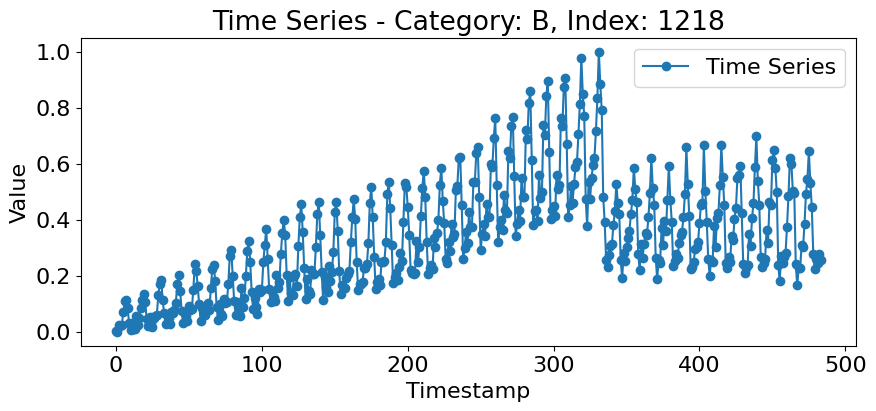

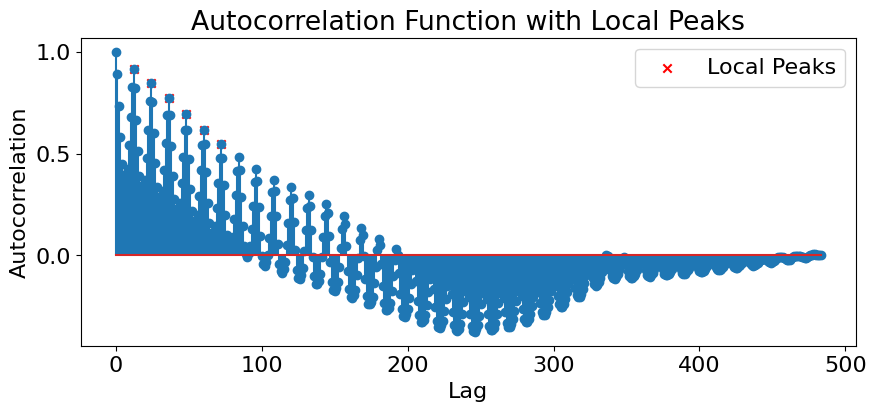

Period used for detrending: 12


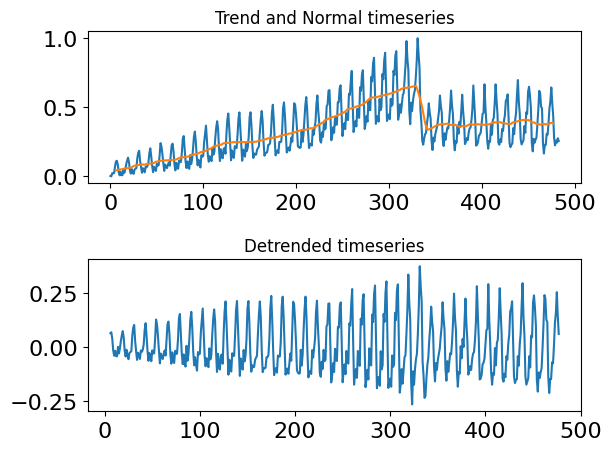

Detrended series contains NaN or Inf values. Check your data.
Window_trend: 3
There is a local peak equal to or greater than 0.5, indicating potential seasonality.
estimated period: 12
[ 12  24  36  48  60  72  84  96 108 120 132 144 156 168 180]


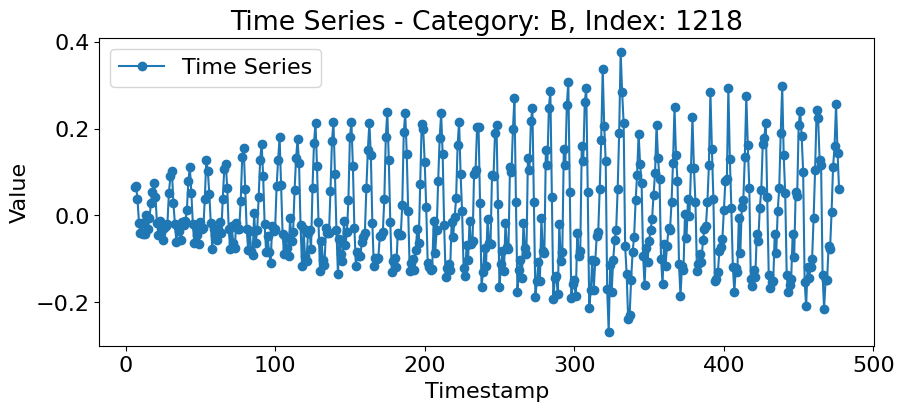

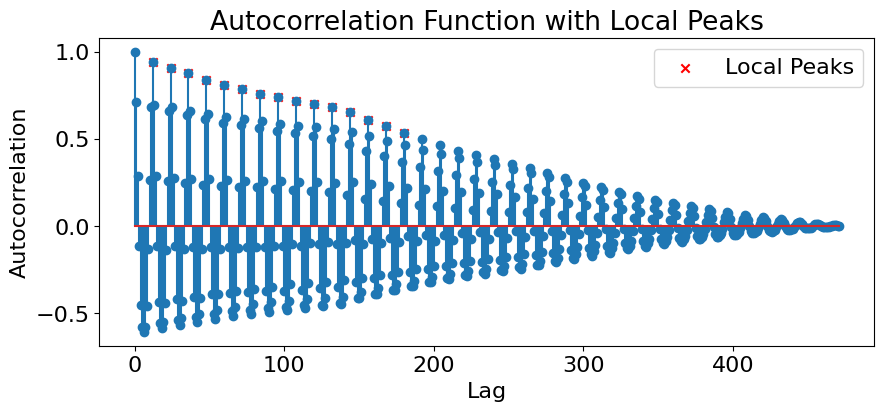

In [214]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

#a good thing to show is 1, 1218

# Select a category and a time series index for comparison
selected_category = unique_categories[1]  # You can choose any category
time_series_index = 1218  # You can choose any time series index
# Extract scaled time series data
scaled_data_dict = train_sets[selected_category]

# Extract relevant timestamp window
start_timestamp = scaled_data_dict['start'][time_series_index]
end_timestamp = scaled_data_dict['end'][time_series_index]

scaled_data_temp = scaled_data_dict['data'][time_series_index, start_timestamp:end_timestamp]

# Calculate the autocorrelation function
acf_result = sm.tsa.acf(scaled_data_temp, nlags=len(scaled_data_temp))

# Find the first timestamp where autocorrelation drops to zero
first_zero_lag = np.argmax(acf_result <= 0.2)

# Check if the autocorrelation never goes to zero
if first_zero_lag == 0:
    print("Autocorrelation never goes to zero.")
    first_zero_lag = len(scaled_data_temp)
    

# Print the first timestamp where autocorrelation drops to zero
print(f"Window_trend: {first_zero_lag}")

# Find local peaks in the autocorrelation function
peaks, _ = find_peaks(acf_result, height=0.5, distance=10)


# Get the values and positions of the local peaks
peak_values = acf_result[peaks]
peak_positions = peaks
print(peak_values)
print(peak_positions)
# Check if any local peak value is equal to or greater than 0.5
if any(peak_values >= 0.5):
    print("There is a local peak equal to or greater than 0.5, indicating potential seasonality.")
    period = peak_positions[0] 
    print(f"estimated period: {period}")
    print(peak_positions)
else:
    print("No significant local peaks equal to or greater than 0.5 found, low chance of seasonality.")

# Plot the timeseries
plt.figure(figsize=(10, 4))
plt.plot(scaled_data_temp, label='Time Series', marker='o')
plt.title(f'Time Series - Category: {selected_category}, Index: {time_series_index}')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot the autocorrelation function with local peaks marked
plt.figure(figsize=(10, 4))
plt.stem(acf_result)
plt.scatter(peak_positions, peak_values, color='red', marker='x', label='Local Peaks')
plt.title('Autocorrelation Function with Local Peaks')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.show()



# Extract scaled time series data
scaled_data_dict = train_sets[selected_category]

# Extract relevant timestamp window
start_timestamp = scaled_data_dict['start'][time_series_index]
end_timestamp = scaled_data_dict['end'][time_series_index]

scaled_data_temp = scaled_data_dict['data'][time_series_index, start_timestamp:end_timestamp]


result_mul = seasonal_decompose(scaled_data_temp, model='additive', period=12)
detrended = scaled_data_temp - result_mul.trend
print(f"Period used for detrending: {period}")


# Create a 2x1 grid for plots
plt.subplot(2, 1, 1)
plt.plot(scaled_data_temp)
plt.title('Normal timeseries', fontsize=12)

plt.subplot(2, 1, 1)
plt.plot(result_mul.trend)
plt.title('Trend and Normal timeseries', fontsize=12)

plt.subplot(2, 1, 2)
plt.plot(detrended)
plt.title('Detrended timeseries', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

# Check for NaN or Inf values in the detrended series
if np.isnan(detrended).any() or np.isinf(detrended).any():
    print("Detrended series contains NaN or Inf values. Check your data.")
else:
    # Check the length of the detrended series
    print("Length of detrended series:", len(detrended))
#print(detrended)

detrended_cleaned = detrended[~np.isnan(detrended)]

#print(detrended_cleaned)
    
# Calculate the autocorrelation function
acf_result = sm.tsa.acf(detrended_cleaned, nlags=len(detrended_cleaned)-1)


# Find the first timestamp where autocorrelation drops to zero
first_zero_lag = np.argmax(acf_result <= 0)

# Check if the autocorrelation never goes to zero
if first_zero_lag == 0:
    print("Autocorrelation never goes to zero.")
    first_zero_lag = len(detrended)
    

# Print the first timestamp where autocorrelation drops to zero
print(f"Window_trend: {first_zero_lag}")

# Find local peaks in the autocorrelation function
peaks, _ = find_peaks(acf_result[first_zero_lag:], height=0.5)


# Get the values and positions of the local peaks
peak_values = acf_result[first_zero_lag + peaks]
peak_positions = peaks + first_zero_lag

# Check if any local peak value is equal to or greater than 0.5
if any(peak_values >= 0.5):
    print("There is a local peak equal to or greater than 0.5, indicating potential seasonality.")
    period = peak_positions[0] 
    print(f"estimated period: {period}")
    print(peak_positions)
else:
    print("No significant local peaks equal to or greater than 0.5 found, low chance of seasonality.")

# Plot the timeseries
plt.figure(figsize=(10, 4))
plt.plot(detrended, label='Time Series', marker='o')
plt.title(f'Time Series - Category: {selected_category}, Index: {time_series_index}')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot the autocorrelation function with local peaks marked

plt.figure(figsize=(10, 4))
plt.stem(acf_result)
plt.scatter(peak_positions, peak_values, color='red', marker='x', label='Local Peaks')

plt.title('Autocorrelation Function with Local Peaks')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.show()


# CREATE the dataset

In [215]:
def build_sequences(train_sets, category, window=50, stride=25, telescope=9):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []

    category_data = train_sets[category]
    time_series_data = category_data['data']
    starts, ends = category_data['start'], category_data['end']
    for i in range(time_series_data.shape[0]):
        # Extract relevant timestamps
        relevant_data = time_series_data[i, starts[i]:ends[i]]
        
        # Iteration for sliding windows
        for start_idx in range(0, len(relevant_data) - window -1, stride):
            end_idx = start_idx + window

            # Check if the sum of the last index of the window and the telescope is greater than the last valid timestamp
            if end_idx + 1 + telescope > ends[i]:
                break  # Stop if the condition is met

            # Create a padded array for the input sequences
            padded_data = np.zeros((window,), dtype='float32')
            padded_data[:window] = relevant_data[start_idx:end_idx]

            # Append to the dataset
            dataset.append(padded_data)

            # Append the labels
            labels.append(relevant_data[end_idx + 1: end_idx + 1 + telescope])


    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

# PLITTING + WINDOWING 

In [216]:
from sklearn.model_selection import train_test_split

# Control the splitting percentage (adjust as needed)
test_size = 0.2  # 20% for testing
validation_size = 0.1  # 10% for validation

# Initialize dictionaries to store train, test, and validation sets for each category
train_sets = {}
test_sets = {}
validation_sets = {}

# Iterate over each category DataFrame
for category, category_df in category_dataframes.items():
    # Extract timestamps and data for each time series in each category
    starts, ends = category_df['Start'].values, category_df['End'].values
    time_series_data = category_df.drop(['Start', 'End', 'Categories'], axis=1).values

    # Split the data into train, test, and validation sets while preserving start and end times
    train_data, test_validation_data, train_start, test_validation_start, train_end, test_validation_end = train_test_split(
        time_series_data, starts, ends, test_size=(test_size + validation_size), random_state=42
    )

    # Further split test_validation_data into test and validation sets
    test_data, validation_data, test_start, validation_start, test_end, validation_end = train_test_split(
        test_validation_data, test_validation_start, test_validation_end, test_size=validation_size/(test_size + validation_size), random_state=42
    )

    # Store the sets in dictionaries
    train_sets[category] = {'data': train_data, 'start': train_start, 'end': train_end}
    test_sets[category] = {'data': test_data, 'start': test_start, 'end': test_end}
    validation_sets[category] = {'data': validation_data, 'start': validation_start, 'end': validation_end}

# Now you have train_sets, test_sets, and validation_sets dictionaries
# Each entry contains the split data along with 'start' and 'end' for the corresponding category and time series.


In [217]:
# Initialize dictionaries to store the number of time series in train, test, and validation sets for each category
train_counts = {}
test_counts = {}
validation_counts = {}

# Iterate over each category DataFrame
for category, _ in category_dataframes.items():
    # Count the number of time series in each set
    train_count = len(train_sets[category]['data'])
    test_count = len(test_sets[category]['data'])
    validation_count = len(validation_sets[category]['data'])

    # Store the counts in dictionaries
    train_counts[category] = train_count
    test_counts[category] = test_count
    validation_counts[category] = validation_count

# Display the results
for category in train_counts:
    print(f"Category {category}:")
    print(f"  Number of Time Series in Train Set: {train_counts[category]}")
    print(f"  Number of Time Series in Test Set: {test_counts[category]}")
    print(f"  Number of Time Series in Validation Set: {validation_counts[category]}")
    print()


Category A:
  Number of Time Series in Train Set: 4009
  Number of Time Series in Test Set: 1146
  Number of Time Series in Validation Set: 573

Category B:
  Number of Time Series in Train Set: 7690
  Number of Time Series in Test Set: 2198
  Number of Time Series in Validation Set: 1099

Category C:
  Number of Time Series in Train Set: 7011
  Number of Time Series in Test Set: 2004
  Number of Time Series in Validation Set: 1002

Category D:
  Number of Time Series in Train Set: 7011
  Number of Time Series in Test Set: 2003
  Number of Time Series in Validation Set: 1002

Category E:
  Number of Time Series in Train Set: 7682
  Number of Time Series in Test Set: 2195
  Number of Time Series in Validation Set: 1098

Category F:
  Number of Time Series in Train Set: 193
  Number of Time Series in Test Set: 56
  Number of Time Series in Validation Set: 28



i'm working with training_sets and not scaled_trainig_sets for now

In [218]:
window = 200
stride = 25
telescope = 9
direct_telescope = 9

In [219]:
def build_sequences(train_sets, category, window=200, stride=25, telescope=9):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []

    category_data = train_sets[category]
    time_series_data = category_data['data']
    starts, ends = category_data['start'], category_data['end']
    
    for i in range(time_series_data.shape[0]):
        # Extract relevant timestamps
        relevant_data = time_series_data[i, starts[i]:ends[i]]
        
        # Iteration for sliding windows
        for start_idx in range(0, len(relevant_data) - window - 1, stride):
            end_idx = start_idx + window

            # Check if the sum of the last index of the window and the telescope is greater than the last valid timestamp
            if end_idx + 1 + telescope > len(relevant_data):
                break  # Stop if the condition is met

            # Create a padded array for the input sequences
            padded_data = np.zeros((window,), dtype='float32')
            padded_data[:window] = relevant_data[start_idx:end_idx]

            # Append to the dataset
            dataset.append(padded_data)

            # Append the labels
            label_slice = relevant_data[end_idx + 1: end_idx + 1 + telescope]
            
            # Debugging information
            #print(f"i: {i}, start_idx: {start_idx}, end_idx: {end_idx}, label_slice: {label_slice}")
            
            # Check the dimension and length of label_slice
            #if len(label_slice) != telescope:
             #   raise ValueError(f"Label slice has unexpected length: {len(label_slice)}, expected: {telescope}")

            # Append the labels
            labels.append(np.array(label_slice))

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels


In [220]:
# Get the unique categories
unique_categories = np.unique(categories)

In [221]:
# Initialize dictionaries to store 
X_train_category_dict = {}
y_train_category_dict = {}
X_test_category_dict = {}
y_test_category_dict = {}
X_validation_category_dict = {}
y_validation_category_dict = {}

# Iterate over each category DataFrame
for category in unique_categories :
    X_train, y_train = build_sequences(train_sets, category, window, stride, direct_telescope)
    X_validation, y_validation = build_sequences(validation_sets, category, window, stride, direct_telescope)
    X_test, y_test = build_sequences(test_sets, category, window, stride, direct_telescope)
    # Store the counts in dictionaries
    X_train_category_dict[category] = X_train
    y_train_category_dict[category] = y_train
    X_test_category_dict[category] = X_test
    y_test_category_dict[category] = y_test
    X_validation_category_dict[category] = X_validation
    y_validation_category_dict[category] = y_validation

In [222]:
# Initialize variables to store total counts
total_train_count = 0
total_test_count = 0
total_validation_count = 0

# Iterate over each unique category
for category in unique_categories:
    # Get the shapes of the sequences for train, test, and validation sets
    shape_train = X_train_category_dict[category].shape
    shape_test = X_test_category_dict[category].shape
    shape_validation = X_validation_category_dict[category].shape

    # Display the shape information
    print(f"Category: {category}")
    print(f"  Train Set Shape: {shape_train}")
    print(f"  Test Set Shape: {shape_test}")
    print(f"  Validation Set Shape: {shape_validation}")

    # Update total counts
    total_train_count += shape_train[0]
    total_test_count += shape_test[0]
    total_validation_count += shape_validation[0]

    print()

# Display the total counts
print("Total Counts:")
print(f"  Total Train Time Series: {total_train_count}")
print(f"  Total Test Time Series: {total_test_count}")
print(f"  Total Validation Time Series: {total_validation_count}")


Category: A
  Train Set Shape: (14805, 200)
  Test Set Shape: (4384, 200)
  Validation Set Shape: (2207, 200)

Category: B
  Train Set Shape: (9772, 200)
  Test Set Shape: (2898, 200)
  Validation Set Shape: (1494, 200)

Category: C
  Train Set Shape: (15534, 200)
  Test Set Shape: (5126, 200)
  Validation Set Shape: (2226, 200)

Category: D
  Train Set Shape: (20225, 200)
  Test Set Shape: (5886, 200)
  Validation Set Shape: (2752, 200)

Category: E
  Train Set Shape: (12982, 200)
  Test Set Shape: (3638, 200)
  Validation Set Shape: (1946, 200)

Category: F
  Train Set Shape: (449, 200)
  Test Set Shape: (77, 200)
  Validation Set Shape: (51, 200)

Total Counts:
  Total Train Time Series: 73767
  Total Test Time Series: 22009
  Total Validation Time Series: 10676


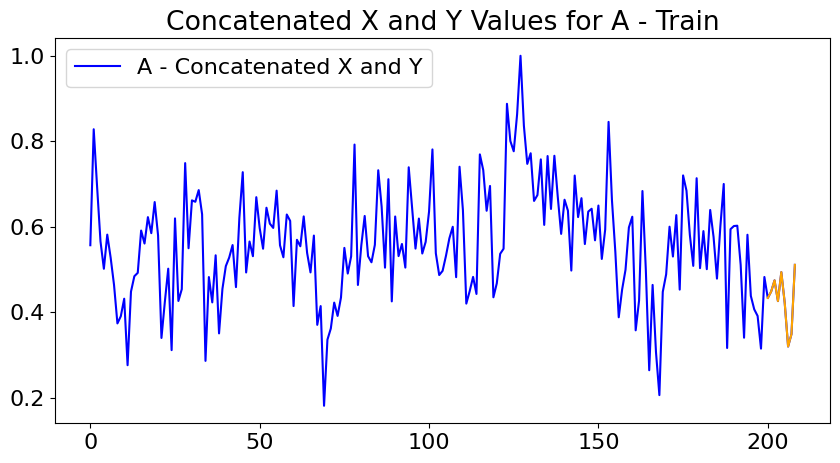

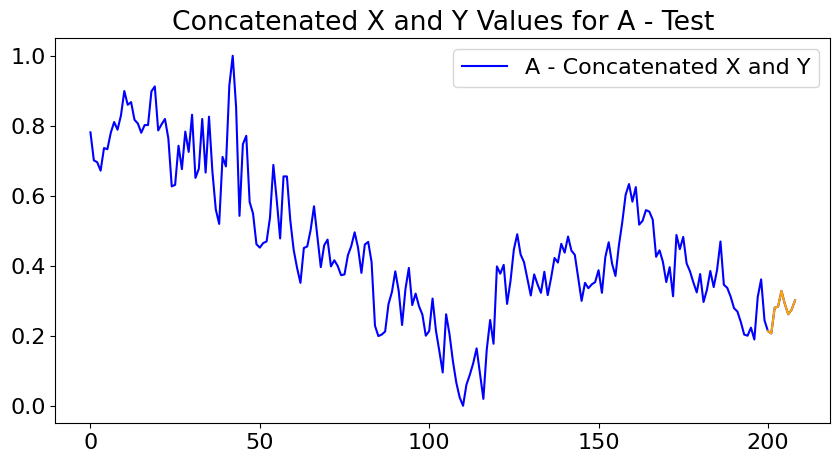

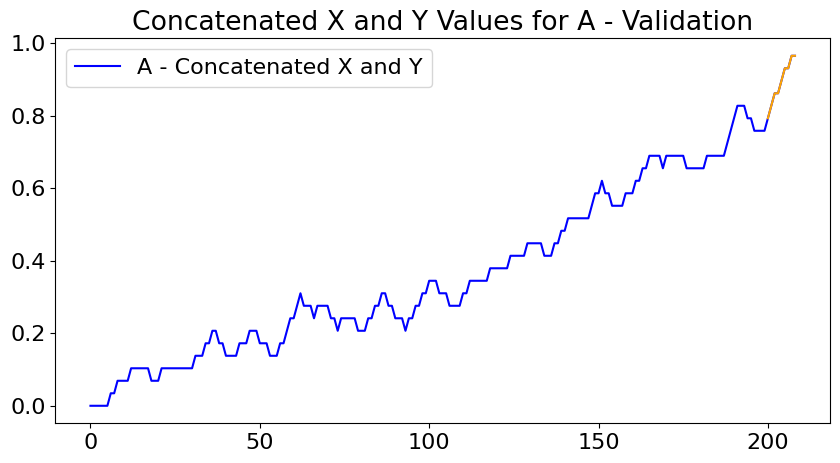

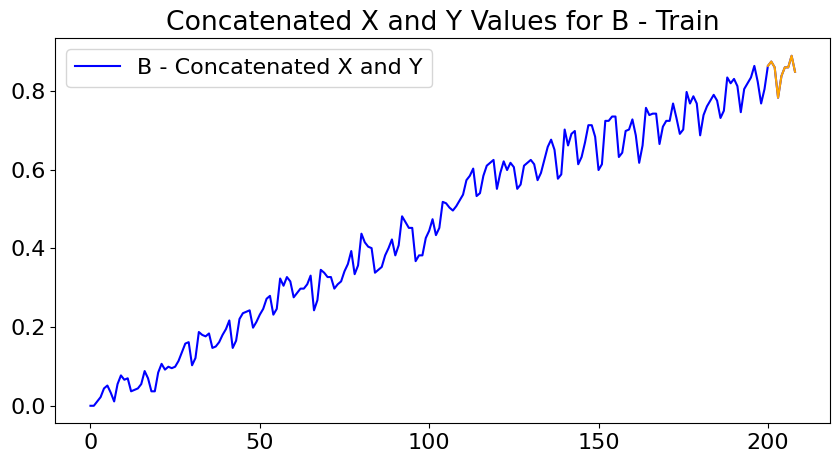

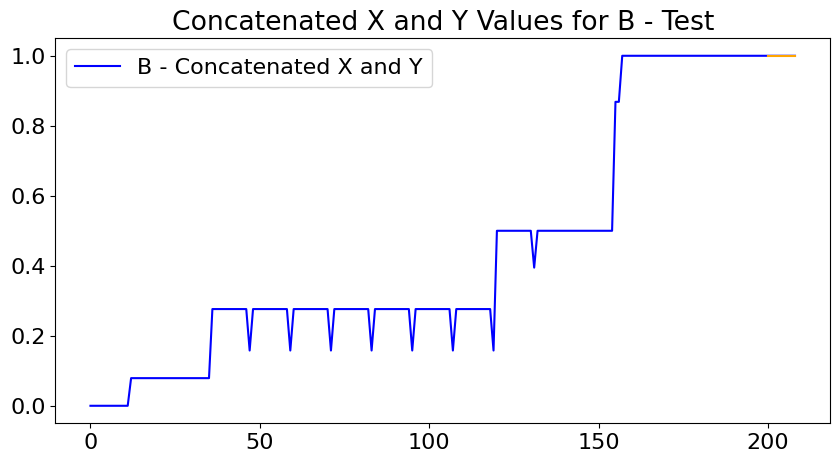

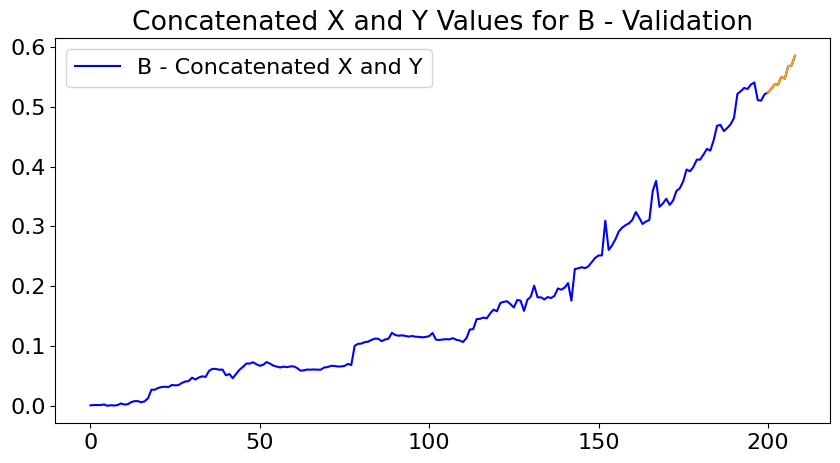

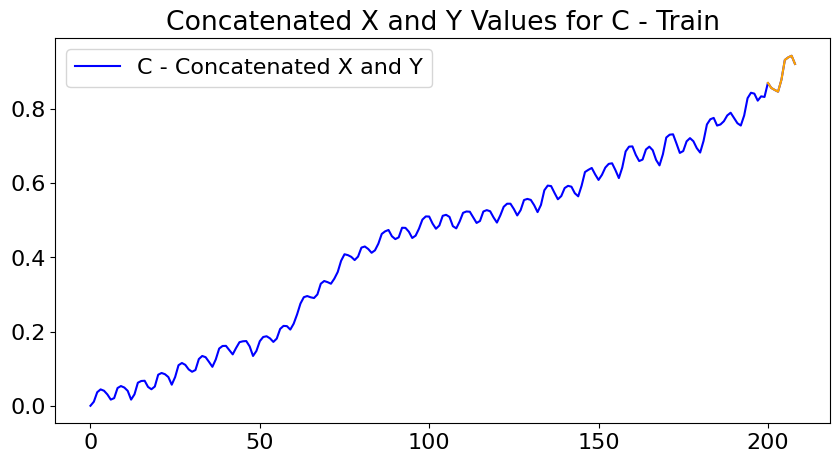

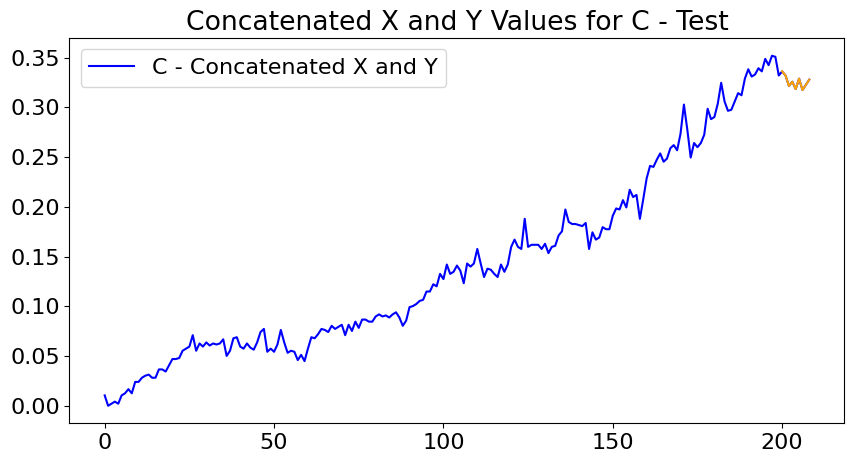

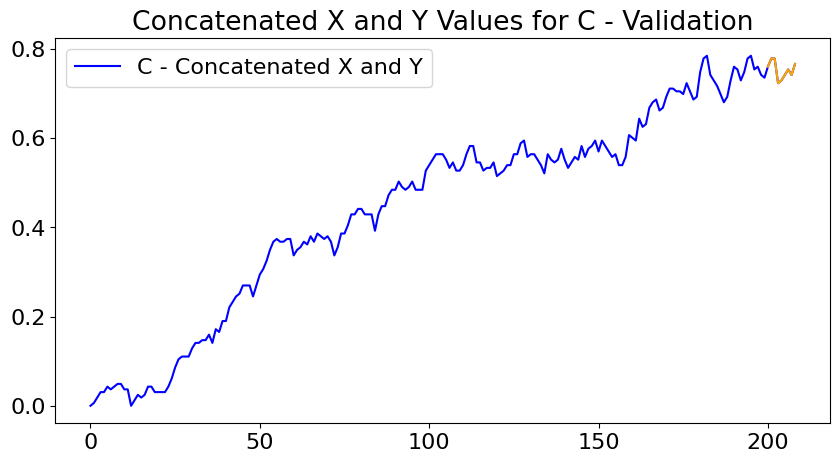

In [223]:
import matplotlib.pyplot as plt

# Choose a few categories to visualize
categories_to_plot = unique_categories[:3]  # Change as needed

# Define colors for x and y in train, test, and validation sets
color_x = 'blue'
color_y = 'orange'

# Iterate through the selected categories
for category in categories_to_plot:
    # Concatenate x and y values for the selected time series from the training set
    combined_train = np.concatenate((X_train_category_dict[category][0], y_train_category_dict[category][0]))

    # Plot the concatenated x and y values in the training set with different colors
    plt.figure(figsize=(10, 5))
    plt.plot(combined_train, label=f'{category} - Concatenated X and Y', color=color_x)
    plt.plot(len(X_train_category_dict[category][0]) + np.arange(len(y_train_category_dict[category][0])), y_train_category_dict[category][0], label='', color=color_y)
    plt.title(f'Concatenated X and Y Values for {category} - Train')
    plt.legend()
    plt.show()

    # Concatenate x and y values for the selected time series from the test set
    combined_test = np.concatenate((X_test_category_dict[category][0], y_test_category_dict[category][0]))

    # Plot the concatenated x and y values in the test set with different colors
    plt.figure(figsize=(10, 5))
    plt.plot(combined_test, label=f'{category} - Concatenated X and Y', color=color_x)
    plt.plot(len(X_test_category_dict[category][0]) + np.arange(len(y_test_category_dict[category][0])), y_test_category_dict[category][0], label='', color=color_y)
    plt.title(f'Concatenated X and Y Values for {category} - Test')
    plt.legend()
    plt.show()

    # Concatenate x and y values for the selected time series from the validation set
    combined_validation = np.concatenate((X_validation_category_dict[category][0], y_validation_category_dict[category][0]))

    # Plot the concatenated x and y values in the validation set with different colors
    plt.figure(figsize=(10, 5))
    plt.plot(combined_validation, label=f'{category} - Concatenated X and Y', color=color_x)
    plt.plot(len(X_validation_category_dict[category][0]) + np.arange(len(y_validation_category_dict[category][0])), y_validation_category_dict[category][0], label='', color=color_y)
    plt.title(f'Concatenated X and Y Values for {category} - Validation')
    plt.legend()
    plt.show()



# Merge all categories 

In [224]:
# Concatenate all categories for train, test, and validation sets
total_train_data = np.concatenate([X_train_category_dict[category] for category in unique_categories])
total_test_data = np.concatenate([X_test_category_dict[category] for category in unique_categories])
total_validation_data = np.concatenate([X_validation_category_dict[category] for category in unique_categories])

# Display the shapes of the combined datasets
print(f"Total Train Set Shape: {total_train_data.shape}")
print(f"Total Test Set Shape: {total_test_data.shape}")
print(f"Total Validation Set Shape: {total_validation_data.shape}")


Total Train Set Shape: (73767, 200)
Total Test Set Shape: (22009, 200)
Total Validation Set Shape: (10676, 200)


In [225]:
# Concatenate all categories for train, test, and validation labels
total_train_labels = np.concatenate([y_train_category_dict[category] for category in unique_categories])
total_test_labels = np.concatenate([y_test_category_dict[category] for category in unique_categories])
total_validation_labels = np.concatenate([y_validation_category_dict[category] for category in unique_categories])

# Display the shapes of the combined label sets
print(f"Total Train Labels Shape: {total_train_labels.shape}")
print(f"Total Test Labels Shape: {total_test_labels.shape}")
print(f"Total Validation Labels Shape: {total_validation_labels.shape}")


Total Train Labels Shape: (73767, 9)
Total Test Labels Shape: (22009, 9)
Total Validation Labels Shape: (10676, 9)


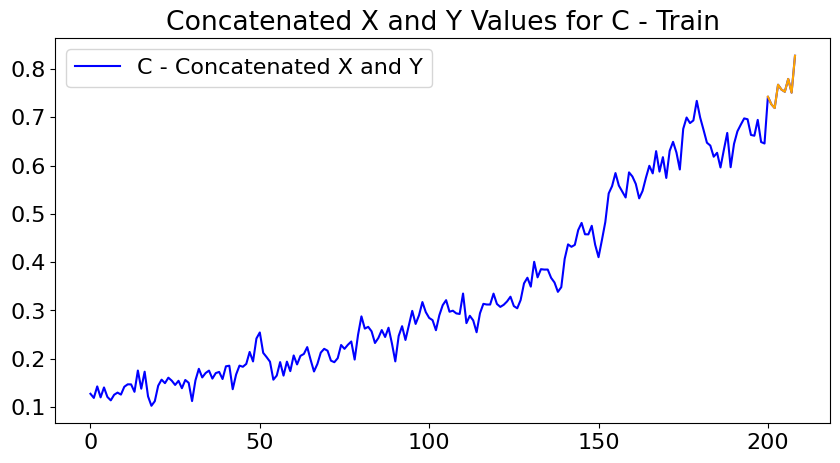

In [226]:
    index=690
    combined_train = np.concatenate((total_train_data[index], total_train_labels[index]))

    # Plot the concatenated x and y values in the training set with different colors
    plt.figure(figsize=(10, 5))
    plt.plot(combined_train, label=f'{category} - Concatenated X and Y', color=color_x)
    plt.plot(len(total_train_data[index]) + np.arange(len(total_train_labels[index])), total_train_labels[index], label='', color=color_y)
    plt.title(f'Concatenated X and Y Values for {category} - Train')
    plt.legend()
    plt.show()

In [227]:
# Combine data and labels for total train, test, and validation sets
total_train_set = np.concatenate([total_train_data, total_train_labels], axis=1)
total_test_set = np.concatenate([total_test_data, total_test_labels], axis=1)
total_validation_set = np.concatenate([total_validation_data, total_validation_labels], axis=1)

# Shuffle the total train set
np.random.shuffle(total_train_set)

# Shuffle the total test set
np.random.shuffle(total_test_set)

# Shuffle the total validation set
np.random.shuffle(total_validation_set)

# Separate shuffled data and labels
shuffled_total_train_data = total_train_set[:, :total_train_data.shape[1]]
shuffled_total_train_labels = total_train_set[:, total_train_data.shape[1]:]

shuffled_total_test_data = total_test_set[:, :total_test_data.shape[1]]
shuffled_total_test_labels = total_test_set[:, total_test_data.shape[1]:]

shuffled_total_validation_data = total_validation_set[:, :total_validation_data.shape[1]]
shuffled_total_validation_labels = total_validation_set[:, total_validation_data.shape[1]:]



# Display the shapes of the shuffled datasets
print(f"Shuffled Total Train Set Shape: {shuffled_total_train_data.shape}")
print(f"Shuffled Total Train Labels Shape: {shuffled_total_train_labels.shape}")

print(f"Shuffled Total Test Set Shape: {shuffled_total_test_data.shape}")
print(f"Shuffled Total Test Labels Shape: {shuffled_total_test_labels.shape}")

print(f"Shuffled Total Validation Set Shape: {shuffled_total_validation_data.shape}")
print(f"Shuffled Total Validation Labels Shape: {shuffled_total_validation_labels.shape}")



Shuffled Total Train Set Shape: (73767, 200)
Shuffled Total Train Labels Shape: (73767, 9)
Shuffled Total Test Set Shape: (22009, 200)
Shuffled Total Test Labels Shape: (22009, 9)
Shuffled Total Validation Set Shape: (10676, 200)
Shuffled Total Validation Labels Shape: (10676, 9)


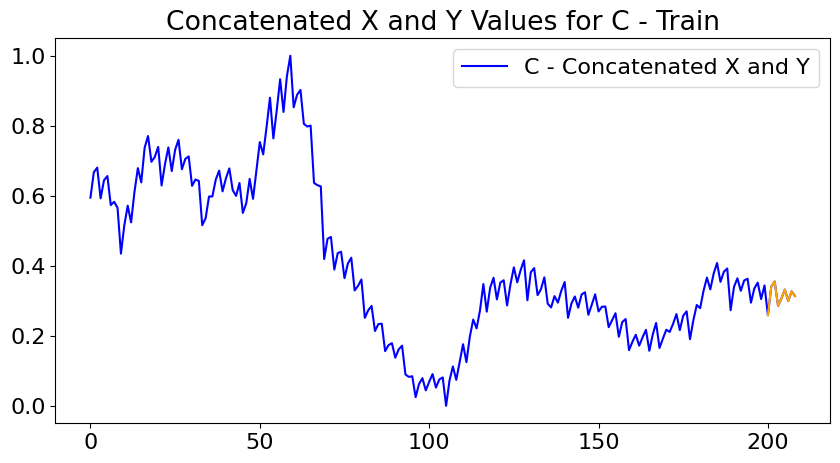

In [228]:
    index=3
    combined_train = np.concatenate((shuffled_total_train_data[index], shuffled_total_train_labels[index]))

    # Plot the concatenated x and y values in the training set with different colors
    plt.figure(figsize=(10, 5))
    plt.plot(combined_train, label=f'{category} - Concatenated X and Y', color=color_x)
    plt.plot(len(shuffled_total_train_data[index]) + np.arange(len(shuffled_total_train_labels[index])), shuffled_total_train_labels[index], label='', color=color_y)
    plt.title(f'Concatenated X and Y Values for {category} - Train')
    plt.legend()
    plt.show()